### Initialization

In [3]:
from pathlib import Path
import open3d as o3d
import os

from pytorch_lightning import seed_everything

from src.dataset_utils import (
    get_singleview_data,
    get_multiview_data,
    get_voxel_data_json,
    get_image_transform_latent_model,
    get_pointcloud_data,
    get_mv_dm_data,
    get_sv_dm_data,
    get_sketch_data
)
from src.model_utils import Model
from src.mvdream_utils import load_mvdream_model
import argparse
from PIL import Image


from comet_ml import start
from comet_ml.integration.pytorch import log_model
from comet_ml.api import API

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import time

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:

def simplify_mesh(obj_path, target_num_faces=1000):
    mesh = o3d.io.read_triangle_mesh(obj_path)
    simplified_mesh = mesh.simplify_quadric_decimation(target_num_faces)
    o3d.io.write_triangle_mesh(obj_path, simplified_mesh)


def generate_3d_object(
    model,
    data,
    data_idx,
    scale,
    diffusion_rescale_timestep,
    image_name,
    save_dir="examples",
    output_format="obj",
    target_num_faces=None,
    seed=42,
    
):
    # Set seed
    seed_everything(seed, workers=True)

    save_dir.mkdir(parents=True, exist_ok=True)
    model.set_inference_fusion_params(scale, diffusion_rescale_timestep)
    output_path = model.test_inference(
        data, data_idx, experiment, image_name = image_name, save_dir=save_dir, output_format=output_format
    )

    if output_format == "obj" and target_num_faces:
        simplify_mesh(output_path, target_num_faces=target_num_faces)

In [3]:
model_name = 'ADSKAILab/WaLa-SV-1B'
images_path = Path('examples/single_view/')
single_image = ['examples/single_view/table.png']

output_dir = 'examples/Test_Gen'
output_format = 'obj'
target_num_faces = None
scale = 1.8
seed = 42
diffusion_rescale_timestep = 5

print(f"Loading model")


model = Model.from_pretrained(pretrained_model_name_or_path=model_name)
image_transform = get_image_transform_latent_model()
model.set_inference_fusion_params(
        scale, diffusion_rescale_timestep
    )
experiment = None

Loading model


/opt/miniconda/envs/wala/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.3.3, which is newer than your current Lightning version: v2.1.0


'DotDict' object has no attribute 'dataset_path'
'DotDict' object has no attribute 'low_avg'
'DotDict' object has no attribute 'low_avg'
Low avg used : None high value: 63


Using cache found in /home/ray/.cache/torch/hub/facebookresearch_dinov2_main
/home/ray/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ray/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ray/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


cond_emb_dim: 1024
Input resolution: 224
Vocab size: N/A
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


### Test 1 - 3 images

In [4]:
def run_inference(image_path,save_dir,model,experiment= None):
    for idx, image_path in enumerate(image_path.iterdir()):  # Enumerate to get the index
        timer1 = time.time()
        print(f"Processing image: {image_path}")
        data = get_singleview_data(
            image_file=Path(image_path),
            image_transform=image_transform,
            device=model.device,
            image_over_white=False,
        )
        data_idx = 0
        save_dir = Path(output_dir) 
        base_name = os.path.basename(image_path)
        image_name = os.path.splitext(base_name)[0]  
        model.set_inference_fusion_params(
            scale, diffusion_rescale_timestep
        )

        generate_3d_object(
            model,
            data,
            data_idx,
            scale,
            diffusion_rescale_timestep,
            image_name,
            save_dir,
            output_format,
            target_num_faces,
            seed,
        )
        delta = time.time() - timer1
        print('Total Inference time', delta)
        try:
            delta = time.time() - timer1
            experiment.log_metric("Default Delta", delta)
            print('Total Inference time', delta)
        except:
            pass
run_inference(images_path,output_dir,model)


Seed set to 42


Processing image: examples/single_view/table.png
Extract Image 0.11360049247741699 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.4062747955322266 s
Latent Decoding Time 0.10675668716430664 s
Wavelet Preparation Time 8.153915405273438e-05 s
Low to Highs conversion 0.2745935916900635 s
Inverse DWT time elapsed 0.011815786361694336 s
mcubes.marching_cubes time 0.6125075817108154 s


Seed set to 42


export obj time 1.1699233055114746 s
Time to save visualization from high lows to obj 1.7946557998657227 s
Total Inference time 4.717087745666504
Processing image: examples/single_view/apple.jpeg
Extract Image 0.014443159103393555 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.339348793029785 s
Latent Decoding Time 0.004341840744018555 s
Wavelet Preparation Time 4.935264587402344e-05 s
Low to Highs conversion 0.10083317756652832 s
Inverse DWT time elapsed 0.003051280975341797 s
mcubes.marching_cubes time 0.5890979766845703 s


Seed set to 42


export obj time 0.9890592098236084 s
Time to save visualization from high lows to obj 1.5813734531402588 s
Total Inference time 4.047784090042114
Processing image: examples/single_view/pear.jpeg
Extract Image 0.015119314193725586 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.341477632522583 s
Latent Decoding Time 0.0042798519134521484 s
Wavelet Preparation Time 5.245208740234375e-05 s
Low to Highs conversion 0.0772697925567627 s
Inverse DWT time elapsed 0.0030307769775390625 s
mcubes.marching_cubes time 0.5510854721069336 s
export obj time 0.8787803649902344 s
Time to save visualization from high lows to obj 1.4333264827728271 s
Total Inference time 3.878417491912842


## Dataset Extraction and Utilization for Benchmarking

In [5]:
import os
import shutil

def find_and_move_matching_files(source_folder, check_folder, destination_folder):
    """
    Finds files in source_folder with names that match files in check_folder,
    and moves the matching files from source_folder to destination_folder.

    Args:
        source_folder (str): Path to the folder containing files to potentially move.
        check_folder (str): Path to the folder containing the reference filenames.
        destination_folder (str): Path to the folder where matching files should be moved.
    """

    try:
        # Get filenames from the check_folder
        check_files = set(os.listdir(check_folder))  # Use a set for faster lookup

        # Create the destination folder if it doesn't exist
        os.makedirs(destination_folder, exist_ok=True)

        # Iterate through files in the source_folder
        for filename in os.listdir(source_folder):
            if filename in check_files:
                source_path = os.path.join(source_folder, filename)
                destination_path = os.path.join(destination_folder, filename)

                # Move the matching file
                shutil.move(source_path, destination_path)
                print(f"Moved: {filename} from {source_folder} to {destination_folder}")

    except FileNotFoundError:
        print("Error: One or more folders not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

source_folder = os.path.expanduser('~/Obj_generated')
destination_folder = Path("/home/ray/WaLa/Benchmark_quality/Original")
check_folder = Path("/home/ray/WaLa/Benchmark_quality/Simplified")

find_and_move_matching_files(source_folder, check_folder, destination_folder)


Moved: 2_of_Jenga_Classic_Game.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 50_BLOCKS.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 5_HTP.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 30_CONSTRUCTION_SET.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 3D_Dollhouse_Swing.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 3M_Antislip_Surfacing_Light_Duty_White.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 3M_Vinyl_Tape_Green_1_x_36_yd.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 3D_Dollhouse_Lamp.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 3D_Dollhouse_Sink.obj from /home/ray/Obj_generated to /home/ray/WaLa/Benchmark_quality/Original
Moved: 3D_Dollhouse_Sofa.obj from /home/ray/Obj_gen

In [4]:
source_folder = os.path.expanduser('~/Obj_generated')
check_folder = Path("/home/ray/WaLa/Benchmark_quality/Original")
destination_folder = Path("/home/ray/WaLa/Benchmark_quality/Simplified")

def check_folder_contents(folder_path):
    """
    Checks the contents of a folder and prints the filenames.

    Args:
        folder_path (str): The path to the folder.
    """
    try:
        filenames = os.listdir(folder_path)
        print(f"Contents of {folder_path}:")
        for filename in filenames:
            print(f"- {filename}")
    except FileNotFoundError:
        print(f"Error: Folder not found: {folder_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Check the contents of each folder
check_folder_contents(source_folder)
check_folder_contents(check_folder)
check_folder_contents(destination_folder)

Contents of /home/ray/Obj_generated:
- 2_of_Jenga_Classic_Game.obj
- 50_BLOCKS.obj
- 5_HTP.obj
- ASICS_GELAce_Pro_Pearl_WhitePink.obj
- ASICS_GELBlur33_20_GS_BlackWhiteSafety_Orange.obj
- Asus_M5A78LMUSB3_Motherboard_Micro_ATX_Socket_AM3.obj
- Asus_M5A99FX_PRO_R20_Motherboard_ATX_Socket_AM3.obj
- Asus_Sabertooth_990FX_20_Motherboard_ATX_Socket_AM3.obj
- Asus_Sabertooth_Z97_MARK_1_Motherboard_ATX_LGA1150_Socket.obj
- BlackBlack_Nintendo_3DSXL.obj
- Black_Decker_Stainless_Steel_Toaster_4_Slice.obj
- Black_Elderberry_Syrup_54_oz_Gaia_Herbs.obj
- BlueBlack_Nintendo_3DSXL.obj
- Blue_Jasmine_Includes_Digital_Copy_UltraViolet_DVD.obj
- Cootie_Game.obj
- Dell_Series_9_Color_Ink_Cartridge_MK993_High_Yield.obj
- Frozen_Scrabble_Jr.obj
- Google_Cardboard_Original_package.obj
- HP_Card_Invitation_Kit.obj
- Hyaluronic_Acid.obj
- LEGO_Creationary_Game.obj
- LEGO_Creationary_Game_ZJa163wlWp2.obj
- Lenovo_Yoga_2_11.obj
- Logitech_Ultimate_Ears_Boom_Wireless_Speaker_Night_Black.obj
- Lovestruck_Tieks_G

### Dataset download and extraction

In [ ]:
import zipfile
from pathlib import Path
import os
import shutil

zip_dir = '/home/ray/WaLa/Raw_data'         # Folder with zip files
output_dir = '/home/ray/WaLa/test_images'  # Where to save extracted thumbnails
os.makedirs(output_dir, exist_ok=True)

for zip_path in Path(zip_dir).glob('*.zip'):
    with zipfile.ZipFile(zip_path, 'r') as z:
        # Find files in the 'thumbnail' folder (not subfolders)
        thumbnail_files = [f for f in z.namelist() if f.startswith('thumbnails/') and not f.endswith('/')]
        if thumbnail_files:
            thumb_file = thumbnail_files[0]  # Pick the first one
            ext = Path(thumb_file).suffix
            out_name = zip_path.stem + ext
            out_path = Path(output_dir) / out_name
            with z.open(thumb_file) as source, open(out_path, 'wb') as target:
                shutil.copyfileobj(source, target)
            print(f"Extracted {thumb_file} from {zip_path.name} as {out_name}")

In [ ]:
from pathlib import Path

def count_extracted_images(target_folder, extensions={'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}):
    """
    Counts the number of image files in the target folder.
    Args:
        target_folder (str or Path): Path to the folder to check.
        extensions (set): Set of file extensions to consider as images.
    Returns:
        int: Number of image files found.
    """
    target_folder = Path(target_folder)
    return sum(1 for f in target_folder.iterdir() if f.suffix.lower() in extensions and f.is_file())

num_images = count_extracted_images('/home/ray/WaLa/test_images')  # Where to save extracted thumbnails
print(f"Extracted images: {num_images}")

Extracted images: 0


In [2]:
import os

def compare_file_sizes(folder1, folder2):
    """
    Compares files with the same name in two folders and prints their sizes and summary stats.
    """
    files1 = set(os.listdir(folder1))
    files2 = set(os.listdir(folder2))
    common_files = files1 & files2

    if not common_files:
        print("No matching files found.")
        return

    total_size1 = 0
    total_size2 = 0

    print(f"{'Filename':40} {'Size in folder1 (bytes)':25} {'Size in folder2 (bytes)':25} {'Difference (bytes)':20}")
    print("-" * 110)
    for filename in sorted(common_files):
        path1 = os.path.join(folder1, filename)
        path2 = os.path.join(folder2, filename)
        size1 = os.path.getsize(path1)
        size2 = os.path.getsize(path2)
        diff = size1 - size2
        total_size1 += size1
        total_size2 += size2
        print(f"{filename:40} {size1:<25} {size2:<25} {diff:<20}")

    total_diff = total_size1 - total_size2
    percent_smaller = (total_diff / total_size1 * 100) if total_size1 else 0

    print("\nSummary:")
    print(f"Total size in folder1: {total_size1} bytes")
    print(f"Total size in folder2: {total_size2} bytes")
    print(f"Total reduction: {total_diff} bytes ({percent_smaller:.2f}% smaller)")

folder1 = "/home/ray/WaLa/Benchmark_quality/Original"
folder2 = "/home/ray/WaLa/Benchmark_quality/Simplified"
compare_file_sizes(folder1, folder2)

Filename                                 Size in folder1 (bytes)   Size in folder2 (bytes)   Difference (bytes)  
--------------------------------------------------------------------------------------------------------------
11pro_SL_TRX_FG.obj                      11575326                  808886                    10766440            
2_of_Jenga_Classic_Game.obj              1969334                   202520                    1766814             
30_CONSTRUCTION_SET.obj                  11295564                  796888                    10498676            
3D_Dollhouse_Happy_Brother.obj           1930472                   231372                    1699100             
3D_Dollhouse_Lamp.obj                    675592                    53940                     621652              
3D_Dollhouse_Refrigerator.obj            13485386                  1069084                   12416302            
3D_Dollhouse_Sink.obj                    20195798                  1204486                 

### Dataset Inference Tests

In [5]:


experiment = start(
  api_key="mqrUAXjKBRul24uX6pxR3gRHX*eyJiYXNlVXJsIjoiaHR0cHM6Ly9jb21ldC5kZXYuY2xvdWRvcy5hdXRvZGVzay5jb20ifQ",
  project_name="wala-time-checks",
  workspace="alessandro-giuliano")


  # Define the hyperparameters
hyperparameters = {
    "model_name": "ADSKAILab/WaLa-SV-1B",
    "images_path": str(Path("examples/single_view/")),
    "single_image": ["examples/single_view/table.png"],
    "output_dir": "examples/Test_Gen",
    "output_format": "obj",
    "target_num_faces": None,
    "scale": 1.8,
    "seed": 42,
    "diffusion_rescale_timestep": 5,
    "Mcubes-Optimized": False,
    "Object-3D_simplified_mesh": '1%',
}

# Log the hyperparameters to Comet
experiment.log_parameters(hyperparameters)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://comet.dev.cloudos.autodesk.com/alessandro-giuliano/wala-time-checks/1ea9c28ff8964d848234a7d10c50f885



In [ ]:
### Scanned Objects by Google Research
google_test_img_path = Path(os.path.expanduser('~/test_images'))  # Expands '~' to the full home directory path
output_dir = os.path.expanduser('~/Obj_generated')

model = Model.from_pretrained(pretrained_model_name_or_path=model_name)
image_transform = get_image_transform_latent_model()

run_inference(google_test_img_path,output_dir,model, experiment)

experiment.end()

/opt/miniconda/envs/wala/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.3.3, which is newer than your current Lightning version: v2.1.0


'DotDict' object has no attribute 'dataset_path'
'DotDict' object has no attribute 'low_avg'
'DotDict' object has no attribute 'low_avg'
Low avg used : None high value: 63


Using cache found in /home/ray/.cache/torch/hub/facebookresearch_dinov2_main


cond_emb_dim: 1024
Input resolution: 224
Vocab size: N/A
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


Seed set to 42


Processing image: /home/ray/test_images/2_of_Jenga_Classic_Game.jpg
Extract Image 0.02161693572998047 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.34004807472229 s
Latent Decoding Time 0.007230043411254883 s
Wavelet Preparation Time 0.0001468658447265625 s
Low to Highs conversion 0.05586695671081543 s
Inverse DWT time elapsed 0.0029976367950439453 s
mcubes.marching_cubes time 0.5429825782775879 s


Seed set to 42


export obj time 0.21264863014221191 s
Time to save visualization from high lows to obj 0.759171724319458 s
Total Inference time 3.1963305473327637
Total Inference time 3.1964027881622314
Processing image: /home/ray/test_images/50_BLOCKS.jpg
Extract Image 0.01556253433227539 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.342914342880249 s
Latent Decoding Time 0.0045664310455322266 s
Wavelet Preparation Time 0.0001575946807861328 s
Low to Highs conversion 0.055418968200683594 s
Inverse DWT time elapsed 0.003207683563232422 s
mcubes.marching_cubes time 0.5464096069335938 s


Seed set to 42


export obj time 0.8602564334869385 s
Time to save visualization from high lows to obj 1.4105656147003174 s
Total Inference time 3.839698314666748
Total Inference time 3.839775800704956
Processing image: /home/ray/test_images/5_HTP.jpg
Extract Image 0.015733957290649414 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.346011161804199 s
Latent Decoding Time 0.0046176910400390625 s
Wavelet Preparation Time 0.00016427040100097656 s
Low to Highs conversion 0.05578947067260742 s
Inverse DWT time elapsed 0.0032737255096435547 s
mcubes.marching_cubes time 0.5549981594085693 s


Seed set to 42


export obj time 1.6446192264556885 s
Time to save visualization from high lows to obj 2.203342914581299 s
Total Inference time 4.636816024780273
Total Inference time 4.636896133422852
Processing image: /home/ray/test_images/ASICS_GELAce_Pro_Pearl_WhitePink.jpg
Extract Image 0.020184993743896484 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.350975751876831 s
Latent Decoding Time 0.004405498504638672 s
Wavelet Preparation Time 0.00016736984252929688 s
Low to Highs conversion 0.056203365325927734 s
Inverse DWT time elapsed 0.003207683563232422 s
mcubes.marching_cubes time 0.5496969223022461 s


Seed set to 42


export obj time 0.9847149848937988 s
Time to save visualization from high lows to obj 1.53824782371521 s
Total Inference time 3.981905221939087
Total Inference time 3.9819839000701904
Processing image: /home/ray/test_images/ASICS_GELBlur33_20_GS_BlackWhiteSafety_Orange.jpg
Extract Image 0.015524148941040039 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3500187397003174 s
Latent Decoding Time 0.0047168731689453125 s
Wavelet Preparation Time 0.0001575946807861328 s
Low to Highs conversion 0.05577874183654785 s
Inverse DWT time elapsed 0.003124713897705078 s
mcubes.marching_cubes time 0.5523128509521484 s


Seed set to 42


export obj time 0.9617652893066406 s
Time to save visualization from high lows to obj 1.5178711414337158 s
Total Inference time 3.9548048973083496
Total Inference time 3.954883337020874
Processing image: /home/ray/test_images/Asus_M5A78LMUSB3_Motherboard_Micro_ATX_Socket_AM3.jpg
Extract Image 0.016043424606323242 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.352494716644287 s
Latent Decoding Time 0.0043599605560302734 s
Wavelet Preparation Time 0.00015306472778320312 s
Low to Highs conversion 0.05578970909118652 s
Inverse DWT time elapsed 0.003186941146850586 s
mcubes.marching_cubes time 0.5587949752807617 s


Seed set to 42


export obj time 1.3902852535247803 s
Time to save visualization from high lows to obj 1.952899694442749 s
Total Inference time 4.393176317214966
Total Inference time 4.393251895904541
Processing image: /home/ray/test_images/Asus_M5A99FX_PRO_R20_Motherboard_ATX_Socket_AM3.jpg
Extract Image 0.016342878341674805 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3518552780151367 s
Latent Decoding Time 0.004584789276123047 s
Wavelet Preparation Time 0.00016307830810546875 s
Low to Highs conversion 0.05591917037963867 s
Inverse DWT time elapsed 0.0029456615447998047 s
mcubes.marching_cubes time 0.5592327117919922 s


Seed set to 42


export obj time 1.6828439235687256 s
Time to save visualization from high lows to obj 2.2456858158111572 s
Total Inference time 4.685927152633667
Total Inference time 4.686004638671875
Processing image: /home/ray/test_images/Asus_Sabertooth_990FX_20_Motherboard_ATX_Socket_AM3.jpg
Extract Image 0.02018904685974121 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.354436159133911 s
Latent Decoding Time 0.0059239864349365234 s
Wavelet Preparation Time 0.0002665519714355469 s
Low to Highs conversion 0.055512189865112305 s
Inverse DWT time elapsed 0.0033066272735595703 s
mcubes.marching_cubes time 0.5870664119720459 s


Seed set to 42


export obj time 1.6417303085327148 s
Time to save visualization from high lows to obj 2.233185052871704 s
Total Inference time 4.680963039398193
Total Inference time 4.681041717529297
Processing image: /home/ray/test_images/Asus_Sabertooth_Z97_MARK_1_Motherboard_ATX_LGA1150_Socket.jpg
Extract Image 0.01584935188293457 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3542518615722656 s
Latent Decoding Time 0.004960060119628906 s
Wavelet Preparation Time 0.00015735626220703125 s
Low to Highs conversion 0.05601811408996582 s
Inverse DWT time elapsed 0.0032682418823242188 s
mcubes.marching_cubes time 0.5605189800262451 s


Seed set to 42


export obj time 1.6227591037750244 s
Time to save visualization from high lows to obj 2.187164783477783 s
Total Inference time 4.629101514816284
Total Inference time 4.629194974899292
Processing image: /home/ray/test_images/BlackBlack_Nintendo_3DSXL.jpg
Extract Image 0.015054941177368164 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.356086015701294 s
Latent Decoding Time 0.0044362545013427734 s
Wavelet Preparation Time 0.00015401840209960938 s
Low to Highs conversion 0.055870771408081055 s
Inverse DWT time elapsed 0.0032701492309570312 s
mcubes.marching_cubes time 0.579108476638794 s


Seed set to 42


export obj time 1.374532699584961 s
Time to save visualization from high lows to obj 1.957606554031372 s
Total Inference time 4.399976015090942
Total Inference time 4.400066375732422
Processing image: /home/ray/test_images/Black_Decker_Stainless_Steel_Toaster_4_Slice.jpg
Extract Image 0.01630997657775879 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3531453609466553 s
Latent Decoding Time 0.0042493343353271484 s
Wavelet Preparation Time 0.00013780593872070312 s
Low to Highs conversion 0.05598258972167969 s
Inverse DWT time elapsed 0.003389120101928711 s
mcubes.marching_cubes time 0.5530250072479248 s


Seed set to 42


export obj time 1.4403564929962158 s
Time to save visualization from high lows to obj 1.9975371360778809 s
Total Inference time 4.438413858413696
Total Inference time 4.438493967056274
Processing image: /home/ray/test_images/Black_Elderberry_Syrup_54_oz_Gaia_Herbs.jpg
Extract Image 0.016027450561523438 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.354722023010254 s
Latent Decoding Time 0.004445552825927734 s
Wavelet Preparation Time 0.00014352798461914062 s
Low to Highs conversion 0.05571126937866211 s
Inverse DWT time elapsed 0.003427267074584961 s
mcubes.marching_cubes time 0.559581995010376 s


Seed set to 42


export obj time 1.900550127029419 s
Time to save visualization from high lows to obj 2.4642670154571533 s
Total Inference time 4.9066596031188965
Total Inference time 4.90673828125
Processing image: /home/ray/test_images/BlueBlack_Nintendo_3DSXL.jpg
Extract Image 0.01590585708618164 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3579213619232178 s
Latent Decoding Time 0.004464387893676758 s
Wavelet Preparation Time 0.00016069412231445312 s
Low to Highs conversion 0.055745601654052734 s
Inverse DWT time elapsed 0.0033042430877685547 s
mcubes.marching_cubes time 0.5539522171020508 s


Seed set to 42


export obj time 1.4066309928894043 s
Time to save visualization from high lows to obj 1.9645862579345703 s
Total Inference time 4.409822940826416
Total Inference time 4.409900665283203
Processing image: /home/ray/test_images/Blue_Jasmine_Includes_Digital_Copy_UltraViolet_DVD.jpg
Extract Image 0.020017385482788086 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.361910104751587 s
Latent Decoding Time 0.006282806396484375 s
Wavelet Preparation Time 0.00020265579223632812 s
Low to Highs conversion 0.05520439147949219 s
Inverse DWT time elapsed 0.003232240676879883 s
mcubes.marching_cubes time 0.5439658164978027 s


Seed set to 42


export obj time 0.2388772964477539 s
Time to save visualization from high lows to obj 0.7867703437805176 s
Total Inference time 3.240934371948242
Total Inference time 3.2410125732421875
Processing image: /home/ray/test_images/Cootie_Game.jpg
Extract Image 0.01594257354736328 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.357417106628418 s
Latent Decoding Time 0.0043985843658447266 s
Wavelet Preparation Time 0.00015616416931152344 s
Low to Highs conversion 0.05586671829223633 s
Inverse DWT time elapsed 0.003217935562133789 s
mcubes.marching_cubes time 0.5505824089050293 s


Seed set to 42


export obj time 0.7714807987213135 s
Time to save visualization from high lows to obj 1.3259634971618652 s
Total Inference time 3.7705488204956055
Total Inference time 3.7706263065338135
Processing image: /home/ray/test_images/Dell_Series_9_Color_Ink_Cartridge_MK993_High_Yield.jpg
Extract Image 0.016052722930908203 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.349867343902588 s
Latent Decoding Time 0.004636049270629883 s
Wavelet Preparation Time 0.00014781951904296875 s
Low to Highs conversion 0.05536174774169922 s
Inverse DWT time elapsed 0.0033364295959472656 s
mcubes.marching_cubes time 0.5491273403167725 s


Seed set to 42


export obj time 0.7963087558746338 s
Time to save visualization from high lows to obj 1.3494551181793213 s
Total Inference time 3.786496639251709
Total Inference time 3.786576747894287
Processing image: /home/ray/test_images/Frozen_Scrabble_Jr.jpg
Extract Image 0.015717506408691406 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3513364791870117 s
Latent Decoding Time 0.004695892333984375 s
Wavelet Preparation Time 0.00019431114196777344 s
Low to Highs conversion 0.05559587478637695 s
Inverse DWT time elapsed 0.003240823745727539 s
mcubes.marching_cubes time 0.5644485950469971 s


Seed set to 42


export obj time 1.5365452766418457 s
Time to save visualization from high lows to obj 2.104886054992676 s
Total Inference time 4.54465913772583
Total Inference time 4.544737339019775
Processing image: /home/ray/test_images/Google_Cardboard_Original_package.jpg
Extract Image 0.015636682510375977 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3489885330200195 s
Latent Decoding Time 0.0045719146728515625 s
Wavelet Preparation Time 0.00020074844360351562 s
Low to Highs conversion 0.05559873580932617 s
Inverse DWT time elapsed 0.003154754638671875 s
mcubes.marching_cubes time 0.5506267547607422 s


Seed set to 42


export obj time 1.0560944080352783 s
Time to save visualization from high lows to obj 1.610421895980835 s
Total Inference time 4.0458984375
Total Inference time 4.04599142074585
Processing image: /home/ray/test_images/HP_Card_Invitation_Kit.jpg
Extract Image 0.027815580368041992 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.349470853805542 s
Latent Decoding Time 0.004658699035644531 s
Wavelet Preparation Time 0.00018334388732910156 s
Low to Highs conversion 0.057094573974609375 s
Inverse DWT time elapsed 0.0032935142517089844 s
mcubes.marching_cubes time 0.5593948364257812 s


Seed set to 42


export obj time 1.8975372314453125 s
Time to save visualization from high lows to obj 2.460937738418579 s
Total Inference time 4.91276216506958
Total Inference time 4.912842035293579
Processing image: /home/ray/test_images/Hyaluronic_Acid.jpg
Extract Image 0.01492166519165039 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3491287231445312 s
Latent Decoding Time 0.00454401969909668 s
Wavelet Preparation Time 0.0001506805419921875 s
Low to Highs conversion 0.055872440338134766 s
Inverse DWT time elapsed 0.0032987594604492188 s
mcubes.marching_cubes time 0.5520870685577393 s


Seed set to 42


export obj time 1.5534260272979736 s
Time to save visualization from high lows to obj 2.109422206878662 s
Total Inference time 4.545641183853149
Total Inference time 4.545714855194092
Processing image: /home/ray/test_images/LEGO_Creationary_Game.jpg
Extract Image 0.015787124633789062 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3495423793792725 s
Latent Decoding Time 0.0043413639068603516 s
Wavelet Preparation Time 0.0001361370086669922 s
Low to Highs conversion 0.05574345588684082 s
Inverse DWT time elapsed 0.003274202346801758 s
mcubes.marching_cubes time 0.5587286949157715 s


Seed set to 42


export obj time 0.8633415699005127 s
Time to save visualization from high lows to obj 1.4262840747833252 s
Total Inference time 3.8625757694244385
Total Inference time 3.862647294998169
Processing image: /home/ray/test_images/LEGO_Creationary_Game_ZJa163wlWp2.jpg
Extract Image 0.015685319900512695 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3488693237304688 s
Latent Decoding Time 0.004747867584228516 s
Wavelet Preparation Time 0.00014209747314453125 s
Low to Highs conversion 0.055917978286743164 s
Inverse DWT time elapsed 0.002936124801635742 s
mcubes.marching_cubes time 0.5532195568084717 s


Seed set to 42


export obj time 1.4171102046966553 s
Time to save visualization from high lows to obj 1.97402024269104 s
Total Inference time 4.411567211151123
Total Inference time 4.411645412445068
Processing image: /home/ray/test_images/Lenovo_Yoga_2_11.jpg
Extract Image 0.0157773494720459 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.353001356124878 s
Latent Decoding Time 0.004450559616088867 s
Wavelet Preparation Time 0.00015616416931152344 s
Low to Highs conversion 0.055806875228881836 s
Inverse DWT time elapsed 0.0031745433807373047 s
mcubes.marching_cubes time 0.5536575317382812 s


Seed set to 42


export obj time 1.201284646987915 s
Time to save visualization from high lows to obj 1.7591145038604736 s
Total Inference time 4.200209617614746
Total Inference time 4.200284719467163
Processing image: /home/ray/test_images/Logitech_Ultimate_Ears_Boom_Wireless_Speaker_Night_Black.jpg
Extract Image 0.015385627746582031 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3547592163085938 s
Latent Decoding Time 0.004434823989868164 s
Wavelet Preparation Time 0.0001506805419921875 s
Low to Highs conversion 0.05579090118408203 s
Inverse DWT time elapsed 0.0032808780670166016 s
mcubes.marching_cubes time 0.5478916168212891 s


Seed set to 42


export obj time 0.996854305267334 s
Time to save visualization from high lows to obj 1.548898458480835 s
Total Inference time 3.990344762802124
Total Inference time 3.990415096282959
Processing image: /home/ray/test_images/Lovestruck_Tieks_Glittery_Rose_Gold_Italian_Leather_Ballet_Flats.jpg
Extract Image 0.014905452728271484 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3488540649414062 s
Latent Decoding Time 0.0042877197265625 s
Wavelet Preparation Time 0.00017714500427246094 s
Low to Highs conversion 0.055687665939331055 s
Inverse DWT time elapsed 0.0032711029052734375 s
mcubes.marching_cubes time 0.5518996715545654 s


Seed set to 42


export obj time 1.2131860256195068 s
Time to save visualization from high lows to obj 1.7690205574035645 s
Total Inference time 4.204148769378662
Total Inference time 4.204272985458374
Processing image: /home/ray/test_images/Luigis_Mansion_Dark_Moon_Nintendo_3DS_Game.jpg
Extract Image 0.015723466873168945 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.349403142929077 s
Latent Decoding Time 0.0048868656158447266 s
Wavelet Preparation Time 0.00024247169494628906 s
Low to Highs conversion 0.05512285232543945 s
Inverse DWT time elapsed 0.003284931182861328 s
mcubes.marching_cubes time 0.5715148448944092 s


Seed set to 42


export obj time 1.023155927658081 s
Time to save visualization from high lows to obj 1.5986454486846924 s
Total Inference time 4.035924673080444
Total Inference time 4.035998106002808
Processing image: /home/ray/test_images/Mens_ASV_Billfish_Boat_Shoe_in_Dark_Brown_Leather_zdHVHXueI3w.jpg
Extract Image 0.016305208206176758 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3473269939422607 s
Latent Decoding Time 0.004876136779785156 s
Wavelet Preparation Time 0.00016546249389648438 s
Low to Highs conversion 0.055726051330566406 s
Inverse DWT time elapsed 0.0031518936157226562 s
mcubes.marching_cubes time 0.5559244155883789 s


Seed set to 42


export obj time 1.1472856998443604 s
Time to save visualization from high lows to obj 1.7069752216339111 s
Total Inference time 4.142481088638306
Total Inference time 4.142560958862305
Processing image: /home/ray/test_images/Mens_Authentic_Original_Boat_Shoe_in_Navy_Leather_xgoEcZtRNmH.jpg
Extract Image 0.015838623046875 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3463804721832275 s
Latent Decoding Time 0.0047550201416015625 s
Wavelet Preparation Time 0.00017690658569335938 s
Low to Highs conversion 0.055619239807128906 s
Inverse DWT time elapsed 0.003420591354370117 s
mcubes.marching_cubes time 0.5537900924682617 s


Seed set to 42


export obj time 1.282604455947876 s
Time to save visualization from high lows to obj 1.8402597904205322 s
Total Inference time 4.273948669433594
Total Inference time 4.274028062820435
Processing image: /home/ray/test_images/Mens_Striper_Sneaker_in_White_rnp8HUli59Y.jpg
Extract Image 0.016179323196411133 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.348397731781006 s
Latent Decoding Time 0.0042896270751953125 s
Wavelet Preparation Time 0.00014066696166992188 s
Low to Highs conversion 0.05593061447143555 s
Inverse DWT time elapsed 0.0033957958221435547 s
mcubes.marching_cubes time 0.5523762702941895 s


Seed set to 42


export obj time 1.4499733448028564 s
Time to save visualization from high lows to obj 2.006371259689331 s
Total Inference time 4.442437171936035
Total Inference time 4.442514657974243
Processing image: /home/ray/test_images/Womens_Audrey_Slip_On_Boat_Shoe_in_Graphite_Nubuck_xWVkCJ5vxZe.jpg
Extract Image 0.015587091445922852 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3474457263946533 s
Latent Decoding Time 0.00452733039855957 s
Wavelet Preparation Time 0.000179290771484375 s
Low to Highs conversion 0.05571722984313965 s
Inverse DWT time elapsed 0.0031812191009521484 s
mcubes.marching_cubes time 0.55076003074646 s


Seed set to 42


export obj time 1.0579609870910645 s
Time to save visualization from high lows to obj 1.6128056049346924 s
Total Inference time 4.046996831893921
Total Inference time 4.047075271606445
Processing image: /home/ray/test_images/Womens_Betty_Chukka_Boot_in_Grey_Jersey_Sequin.jpg
Extract Image 0.016037940979003906 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.347666025161743 s
Latent Decoding Time 0.0061473846435546875 s
Wavelet Preparation Time 0.00019216537475585938 s
Low to Highs conversion 0.05543684959411621 s
Inverse DWT time elapsed 0.003161907196044922 s
mcubes.marching_cubes time 0.5540080070495605 s


Seed set to 42


export obj time 0.9843082427978516 s
Time to save visualization from high lows to obj 1.5421257019042969 s
Total Inference time 3.9786391258239746
Total Inference time 3.978726625442505
Processing image: /home/ray/test_images/Womens_Betty_Chukka_Boot_in_Salt_Washed_Red_AL2YrOt9CRy.jpg
Extract Image 0.015823841094970703 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3484625816345215 s
Latent Decoding Time 0.004581928253173828 s
Wavelet Preparation Time 0.0001506805419921875 s
Low to Highs conversion 0.05604696273803711 s
Inverse DWT time elapsed 0.0034787654876708984 s
mcubes.marching_cubes time 0.5479013919830322 s


Seed set to 42


export obj time 0.7809302806854248 s
Time to save visualization from high lows to obj 1.3329415321350098 s
Total Inference time 3.7687602043151855
Total Inference time 3.76883864402771
Processing image: /home/ray/test_images/Womens_Bluefish_2Eye_Boat_Shoe_in_White_Tumbled_YG44xIePRHw.jpg
Extract Image 0.015761613845825195 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3479673862457275 s
Latent Decoding Time 0.004259347915649414 s
Wavelet Preparation Time 0.0001404285430908203 s
Low to Highs conversion 0.056025028228759766 s
Inverse DWT time elapsed 0.0032465457916259766 s
mcubes.marching_cubes time 0.5502140522003174 s


Seed set to 42


export obj time 1.239107370376587 s
Time to save visualization from high lows to obj 1.7933173179626465 s
Total Inference time 4.228705167770386
Total Inference time 4.228785276412964
Processing image: /home/ray/test_images/30_CONSTRUCTION_SET.jpg
Extract Image 0.021226167678833008 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.34938645362854 s
Latent Decoding Time 0.00445556640625 s
Wavelet Preparation Time 0.00014162063598632812 s
Low to Highs conversion 0.05575847625732422 s
Inverse DWT time elapsed 0.003308534622192383 s
mcubes.marching_cubes time 0.5500061511993408 s


Seed set to 42


export obj time 1.0474956035614014 s
Time to save visualization from high lows to obj 1.601494312286377 s
Total Inference time 4.045125484466553
Total Inference time 4.04521107673645
Processing image: /home/ray/test_images/3D_Dollhouse_Swing.jpg
Extract Image 0.01574420928955078 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3455944061279297 s
Latent Decoding Time 0.004279375076293945 s
Wavelet Preparation Time 0.00014543533325195312 s
Low to Highs conversion 0.05567479133605957 s
Inverse DWT time elapsed 0.003287792205810547 s
mcubes.marching_cubes time 0.553537130355835 s


Seed set to 42


export obj time 1.6110730171203613 s
Time to save visualization from high lows to obj 2.168539047241211 s
Total Inference time 4.6008219718933105
Total Inference time 4.6008994579315186
Processing image: /home/ray/test_images/3M_Antislip_Surfacing_Light_Duty_White.jpg
Extract Image 0.016499042510986328 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.34847354888916 s
Latent Decoding Time 0.004682064056396484 s
Wavelet Preparation Time 0.0001475811004638672 s
Low to Highs conversion 0.05572509765625 s
Inverse DWT time elapsed 0.003438711166381836 s
mcubes.marching_cubes time 0.5495765209197998 s


Seed set to 42


export obj time 0.9817814826965332 s
Time to save visualization from high lows to obj 1.5354299545288086 s
Total Inference time 3.9731340408325195
Total Inference time 3.973209857940674
Processing image: /home/ray/test_images/3M_Vinyl_Tape_Green_1_x_36_yd.jpg
Extract Image 0.0156252384185791 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.34675669670105 s
Latent Decoding Time 0.004534006118774414 s
Wavelet Preparation Time 0.00015807151794433594 s
Low to Highs conversion 0.05594229698181152 s
Inverse DWT time elapsed 0.0033109188079833984 s
mcubes.marching_cubes time 0.5485332012176514 s


Seed set to 42


export obj time 1.0292251110076904 s
Time to save visualization from high lows to obj 1.5817334651947021 s
Total Inference time 4.015532970428467
Total Inference time 4.015604019165039
Processing image: /home/ray/test_images/Animal_Planet_Foam_2Headed_Dragon.jpg
Extract Image 0.01578497886657715 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3473925590515137 s
Latent Decoding Time 0.0049135684967041016 s
Wavelet Preparation Time 0.00016617774963378906 s
Low to Highs conversion 0.05585122108459473 s
Inverse DWT time elapsed 0.003200054168701172 s
mcubes.marching_cubes time 0.5530533790588379 s


Seed set to 42


export obj time 0.7222123146057129 s
Time to save visualization from high lows to obj 1.2791435718536377 s
Total Inference time 3.714616060256958
Total Inference time 3.7146949768066406
Processing image: /home/ray/test_images/Avengers_Thor_PLlrpYniaeB.jpg
Extract Image 0.015877962112426758 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.347383737564087 s
Latent Decoding Time 0.0047266483306884766 s
Wavelet Preparation Time 0.00016999244689941406 s
Low to Highs conversion 0.05612659454345703 s
Inverse DWT time elapsed 0.003174304962158203 s
mcubes.marching_cubes time 0.5603857040405273 s


Seed set to 42


export obj time 2.0056521892547607 s
Time to save visualization from high lows to obj 2.569819688796997 s
Total Inference time 5.005796909332275
Total Inference time 5.005868911743164
Processing image: /home/ray/test_images/BEDROOM_CLASSIC.jpg
Extract Image 0.017946720123291016 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.348479986190796 s
Latent Decoding Time 0.00490260124206543 s
Wavelet Preparation Time 0.0001888275146484375 s
Low to Highs conversion 0.05601215362548828 s
Inverse DWT time elapsed 0.0032722949981689453 s
mcubes.marching_cubes time 0.5582635402679443 s


Seed set to 42


export obj time 0.9227197170257568 s
Time to save visualization from high lows to obj 1.4848604202270508 s
Total Inference time 3.9228336811065674
Total Inference time 3.922910451889038
Processing image: /home/ray/test_images/BIA_Cordon_Bleu_White_Porcelain_Utensil_Holder_900028.jpg
Extract Image 0.015720605850219727 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3491194248199463 s
Latent Decoding Time 0.004584550857543945 s
Wavelet Preparation Time 0.0001404285430908203 s
Low to Highs conversion 0.05582547187805176 s
Inverse DWT time elapsed 0.0039005279541015625 s
mcubes.marching_cubes time 0.561143159866333 s


Seed set to 42


export obj time 2.5487678050994873 s
Time to save visualization from high lows to obj 3.114647150039673 s
Total Inference time 5.551509380340576
Total Inference time 5.551599502563477
Processing image: /home/ray/test_images/CONE_SORTING.jpg
Extract Image 0.015861988067626953 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.349134683609009 s
Latent Decoding Time 0.0045680999755859375 s
Wavelet Preparation Time 0.00013971328735351562 s
Low to Highs conversion 0.05590629577636719 s
Inverse DWT time elapsed 0.0030171871185302734 s
mcubes.marching_cubes time 0.5514845848083496 s


Seed set to 42


export obj time 1.5641484260559082 s
Time to save visualization from high lows to obj 2.1193621158599854 s
Total Inference time 4.555728912353516
Total Inference time 4.555801630020142
Processing image: /home/ray/test_images/Clorox_Premium_Choice_Gloves_SM_1_pair.jpg
Extract Image 0.015984058380126953 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3493611812591553 s
Latent Decoding Time 0.004480600357055664 s
Wavelet Preparation Time 0.0001437664031982422 s
Low to Highs conversion 0.05585741996765137 s
Inverse DWT time elapsed 0.0031766891479492188 s
mcubes.marching_cubes time 0.5415463447570801 s


Seed set to 42


export obj time 0.26871776580810547 s
Time to save visualization from high lows to obj 0.8140685558319092 s
Total Inference time 3.2502918243408203
Total Inference time 3.2503647804260254
Processing image: /home/ray/test_images/Cole_Hardware_Deep_Bowl_Good_Earth_1075.jpg
Extract Image 0.015290498733520508 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3468809127807617 s
Latent Decoding Time 0.004320383071899414 s
Wavelet Preparation Time 0.0001380443572998047 s
Low to Highs conversion 0.05602073669433594 s
Inverse DWT time elapsed 0.003273487091064453 s
mcubes.marching_cubes time 0.5543034076690674 s


Seed set to 42


export obj time 1.6947669982910156 s
Time to save visualization from high lows to obj 2.2530570030212402 s
Total Inference time 4.68567681312561
Total Inference time 4.685752868652344
Processing image: /home/ray/test_images/Cole_Hardware_Dishtowel_BlueWhite.jpg
Extract Image 0.015609264373779297 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3496365547180176 s
Latent Decoding Time 0.004616975784301758 s
Wavelet Preparation Time 0.0001475811004638672 s
Low to Highs conversion 0.05667877197265625 s
Inverse DWT time elapsed 0.0032415390014648438 s
mcubes.marching_cubes time 0.5642776489257812 s


Seed set to 42


export obj time 0.8232631683349609 s
Time to save visualization from high lows to obj 1.3914411067962646 s
Total Inference time 3.829085111618042
Total Inference time 3.8291637897491455
Processing image: /home/ray/test_images/Cole_Hardware_Hammer_Black.jpg
Extract Image 0.016524553298950195 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.348966121673584 s
Latent Decoding Time 0.004538774490356445 s
Wavelet Preparation Time 0.00014638900756835938 s
Low to Highs conversion 0.05590224266052246 s
Inverse DWT time elapsed 0.002969980239868164 s
mcubes.marching_cubes time 0.5485162734985352 s


Seed set to 42


export obj time 0.4915752410888672 s
Time to save visualization from high lows to obj 1.0437324047088623 s
Total Inference time 3.4798386096954346
Total Inference time 3.479917526245117
Processing image: /home/ray/test_images/Cole_Hardware_Mini_Honey_Dipper.jpg
Extract Image 0.01558828353881836 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.348550319671631 s
Latent Decoding Time 0.004500389099121094 s
Wavelet Preparation Time 0.00015020370483398438 s
Low to Highs conversion 0.05555438995361328 s
Inverse DWT time elapsed 0.0031633377075195312 s
mcubes.marching_cubes time 0.5448031425476074 s


Seed set to 42


export obj time 0.3073105812072754 s
Time to save visualization from high lows to obj 0.8559262752532959 s
Total Inference time 3.2911124229431152
Total Inference time 3.2911932468414307
Processing image: /home/ray/test_images/Cole_Hardware_Plant_Saucer_Brown_125.jpg
Extract Image 0.015493631362915039 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.350696086883545 s
Latent Decoding Time 0.004448652267456055 s
Wavelet Preparation Time 0.00013709068298339844 s
Low to Highs conversion 0.05566215515136719 s
Inverse DWT time elapsed 0.003215312957763672 s
mcubes.marching_cubes time 0.5499916076660156 s


Seed set to 42


export obj time 1.0538876056671143 s
Time to save visualization from high lows to obj 1.6077799797058105 s
Total Inference time 4.044231176376343
Total Inference time 4.044302701950073
Processing image: /home/ray/test_images/Deskstar_Desk_Top_Hard_Drive_1_TB.jpg
Extract Image 0.015505552291870117 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3494374752044678 s
Latent Decoding Time 0.004441738128662109 s
Wavelet Preparation Time 0.0001423358917236328 s
Low to Highs conversion 0.05596780776977539 s
Inverse DWT time elapsed 0.0031135082244873047 s
mcubes.marching_cubes time 0.5496377944946289 s


Seed set to 42


export obj time 1.652984380722046 s
Time to save visualization from high lows to obj 2.2064170837402344 s
Total Inference time 4.642612934112549
Total Inference time 4.642685890197754
Processing image: /home/ray/test_images/Cole_Hardware_Saucer_Glazed_6.jpg
Extract Image 0.015408992767333984 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3512585163116455 s
Latent Decoding Time 0.004607200622558594 s
Wavelet Preparation Time 0.0001430511474609375 s
Low to Highs conversion 0.05566763877868652 s
Inverse DWT time elapsed 0.00325775146484375 s
mcubes.marching_cubes time 0.5508537292480469 s


Seed set to 42


export obj time 1.169956922531128 s
Time to save visualization from high lows to obj 1.7248079776763916 s
Total Inference time 4.16215705871582
Total Inference time 4.162240266799927
Processing image: /home/ray/test_images/Diet_Pepsi_Soda_Cola12_Pack_12_oz_Cans.jpg
Extract Image 0.015924453735351562 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.349912405014038 s
Latent Decoding Time 0.004503011703491211 s
Wavelet Preparation Time 0.00014710426330566406 s
Low to Highs conversion 0.05597257614135742 s
Inverse DWT time elapsed 0.003045320510864258 s
mcubes.marching_cubes time 0.553851842880249 s


Seed set to 42


export obj time 1.0029184818267822 s
Time to save visualization from high lows to obj 1.560441493988037 s
Total Inference time 3.9982409477233887
Total Inference time 3.9983136653900146
Processing image: /home/ray/test_images/Ecoforms_Cup_B4_SAN.jpg
Extract Image 0.01580071449279785 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.347111701965332 s
Latent Decoding Time 0.0043561458587646484 s
Wavelet Preparation Time 0.00013780593872070312 s
Low to Highs conversion 0.05600714683532715 s
Inverse DWT time elapsed 0.003201007843017578 s
mcubes.marching_cubes time 0.5590779781341553 s


Seed set to 42


export obj time 2.2239410877227783 s
Time to save visualization from high lows to obj 2.78688383102417 s
Total Inference time 5.220947742462158
Total Inference time 5.2210307121276855
Processing image: /home/ray/test_images/Ecoforms_Plant_Container_B4_Har.jpg
Extract Image 0.01586771011352539 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.349508285522461 s
Latent Decoding Time 0.004681110382080078 s
Wavelet Preparation Time 0.00016355514526367188 s
Low to Highs conversion 0.05585813522338867 s
Inverse DWT time elapsed 0.003200531005859375 s
mcubes.marching_cubes time 0.5605311393737793 s


Seed set to 42


export obj time 2.2439181804656982 s
Time to save visualization from high lows to obj 2.808340072631836 s
Total Inference time 5.245236873626709
Total Inference time 5.245325565338135
Processing image: /home/ray/test_images/Ecoforms_Plant_Container_GP16AMOCHA.jpg
Extract Image 0.015787124633789062 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3488829135894775 s
Latent Decoding Time 0.0047566890716552734 s
Wavelet Preparation Time 0.00017070770263671875 s
Low to Highs conversion 0.055665016174316406 s
Inverse DWT time elapsed 0.003097057342529297 s
mcubes.marching_cubes time 0.5668723583221436 s


Seed set to 42


export obj time 2.6201422214508057 s
Time to save visualization from high lows to obj 3.1907765865325928 s
Total Inference time 5.627129554748535
Total Inference time 5.62720799446106
Processing image: /home/ray/test_images/Ecoforms_Plant_Container_GP16A_Coral.jpg
Extract Image 0.016505718231201172 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3489744663238525 s
Latent Decoding Time 0.004885673522949219 s
Wavelet Preparation Time 0.0001537799835205078 s
Low to Highs conversion 0.055576324462890625 s
Inverse DWT time elapsed 0.0031909942626953125 s
mcubes.marching_cubes time 0.5687973499298096 s


Seed set to 42


export obj time 2.6392452716827393 s
Time to save visualization from high lows to obj 3.2116971015930176 s
Total Inference time 5.64876127243042
Total Inference time 5.648842096328735
Processing image: /home/ray/test_images/Ecoforms_Plant_Container_QP6HARVEST.jpg
Extract Image 0.02297067642211914 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.356335163116455 s
Latent Decoding Time 0.0048732757568359375 s
Wavelet Preparation Time 0.00015997886657714844 s
Low to Highs conversion 0.05594134330749512 s
Inverse DWT time elapsed 0.003156900405883789 s
mcubes.marching_cubes time 0.6268832683563232 s


Seed set to 42


export obj time 2.1610727310180664 s
Time to save visualization from high lows to obj 2.7915878295898438 s
Total Inference time 5.244505882263184
Total Inference time 5.244598627090454
Processing image: /home/ray/test_images/Ecoforms_Plant_Container_URN_NAT.jpg
Extract Image 0.015921592712402344 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3511452674865723 s
Latent Decoding Time 0.0042498111724853516 s
Wavelet Preparation Time 0.0001373291015625 s
Low to Highs conversion 0.055727481842041016 s
Inverse DWT time elapsed 0.0031180381774902344 s
mcubes.marching_cubes time 0.5612168312072754 s


Seed set to 42


export obj time 2.381880044937134 s
Time to save visualization from high lows to obj 2.9468469619750977 s
Total Inference time 5.38581109046936
Total Inference time 5.385889053344727
Processing image: /home/ray/test_images/Ecoforms_Plant_Container_Urn_55_Mocha.jpg
Extract Image 0.015834569931030273 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3540239334106445 s
Latent Decoding Time 0.004838228225708008 s
Wavelet Preparation Time 0.000156402587890625 s
Low to Highs conversion 0.05555558204650879 s
Inverse DWT time elapsed 0.003188610076904297 s
mcubes.marching_cubes time 0.5669081211090088 s


Seed set to 42


export obj time 2.366772174835205 s
Time to save visualization from high lows to obj 2.93756103515625 s
Total Inference time 5.378350019454956
Total Inference time 5.378422021865845
Processing image: /home/ray/test_images/Ecoforms_Plant_Pot_GP9_SAND.jpg
Extract Image 0.014873266220092773 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.351654291152954 s
Latent Decoding Time 0.004660129547119141 s
Wavelet Preparation Time 0.00014066696166992188 s
Low to Highs conversion 0.05552816390991211 s
Inverse DWT time elapsed 0.0032553672790527344 s
mcubes.marching_cubes time 0.5604672431945801 s


Seed set to 42


export obj time 2.559084177017212 s
Time to save visualization from high lows to obj 3.123225688934326 s
Total Inference time 5.562582969665527
Total Inference time 5.562665700912476
Processing image: /home/ray/test_images/Ecoforms_Plant_Saucer_S17MOCHA.jpg
Extract Image 0.014806747436523438 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3489575386047363 s
Latent Decoding Time 0.0047986507415771484 s
Wavelet Preparation Time 0.00015163421630859375 s
Low to Highs conversion 0.055963993072509766 s
Inverse DWT time elapsed 0.0032944679260253906 s
mcubes.marching_cubes time 0.5502855777740479 s


Seed set to 42


export obj time 1.1335711479187012 s
Time to save visualization from high lows to obj 1.6875646114349365 s
Total Inference time 4.123397588729858
Total Inference time 4.123469591140747
Processing image: /home/ray/test_images/Ecoforms_Planter_Bowl_Cole_Hardware.jpg
Extract Image 0.01531982421875 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.356208086013794 s
Latent Decoding Time 0.004427909851074219 s
Wavelet Preparation Time 0.00014019012451171875 s
Low to Highs conversion 0.05571103096008301 s
Inverse DWT time elapsed 0.0031599998474121094 s
mcubes.marching_cubes time 0.5596165657043457 s


Seed set to 42


export obj time 2.0949416160583496 s
Time to save visualization from high lows to obj 2.658453941345215 s
Total Inference time 5.10109806060791
Total Inference time 5.101171970367432
Processing image: /home/ray/test_images/Elephant.jpg
Extract Image 0.019928932189941406 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3576643466949463 s
Latent Decoding Time 0.00466465950012207 s
Wavelet Preparation Time 0.0001842975616455078 s
Low to Highs conversion 0.055582523345947266 s
Inverse DWT time elapsed 0.003289937973022461 s
mcubes.marching_cubes time 0.5570626258850098 s


Seed set to 42


export obj time 1.3048608303070068 s
Time to save visualization from high lows to obj 1.8658578395843506 s
Total Inference time 4.317578554153442
Total Inference time 4.317656517028809
Processing image: /home/ray/test_images/Gigabyte_GAZ97XSLI_10_motherboard_ATX_LGA1150_Socket_Z97.jpg
Extract Image 0.01627373695373535 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.360020399093628 s
Latent Decoding Time 0.004567623138427734 s
Wavelet Preparation Time 0.00016117095947265625 s
Low to Highs conversion 0.05562448501586914 s
Inverse DWT time elapsed 0.0035774707794189453 s
mcubes.marching_cubes time 0.567652702331543 s


Seed set to 42


export obj time 1.9809329509735107 s
Time to save visualization from high lows to obj 2.552860975265503 s
Total Inference time 5.00101900100708
Total Inference time 5.0010905265808105
Processing image: /home/ray/test_images/Granimals_20_Wooden_ABC_Blocks_Wagon.jpg
Extract Image 0.015622138977050781 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3505382537841797 s
Latent Decoding Time 0.0045206546783447266 s
Wavelet Preparation Time 0.00014090538024902344 s
Low to Highs conversion 0.05564570426940918 s
Inverse DWT time elapsed 0.0030622482299804688 s
mcubes.marching_cubes time 0.55000901222229 s


Seed set to 42


export obj time 0.849480390548706 s
Time to save visualization from high lows to obj 1.4033088684082031 s
Total Inference time 3.8402678966522217
Total Inference time 3.840345621109009
Processing image: /home/ray/test_images/Great_Dinos_Triceratops_Toy.jpg
Extract Image 0.015596151351928711 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3488316535949707 s
Latent Decoding Time 0.004374027252197266 s
Wavelet Preparation Time 0.00013685226440429688 s
Low to Highs conversion 0.05592179298400879 s
Inverse DWT time elapsed 0.0029959678649902344 s
mcubes.marching_cubes time 0.5494520664215088 s


Seed set to 42


export obj time 1.2564382553100586 s
Time to save visualization from high lows to obj 1.8095917701721191 s
Total Inference time 4.247268199920654
Total Inference time 4.24734091758728
Processing image: /home/ray/test_images/Hefty_Waste_Basket_Decorative_Bronze_85_liter.jpg
Extract Image 0.015677452087402344 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3481533527374268 s
Latent Decoding Time 0.004723787307739258 s
Wavelet Preparation Time 0.0001399517059326172 s
Low to Highs conversion 0.05589175224304199 s
Inverse DWT time elapsed 0.0030829906463623047 s
mcubes.marching_cubes time 0.5576560497283936 s


Seed set to 42


export obj time 2.254204750061035 s
Time to save visualization from high lows to obj 2.8155059814453125 s
Total Inference time 5.250951766967773
Total Inference time 5.251022100448608
Processing image: /home/ray/test_images/INTERNATIONAL_PAPER_Willamette_4_Brown_Bag_500Count.jpg
Extract Image 0.01528310775756836 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3509938716888428 s
Latent Decoding Time 0.004409074783325195 s
Wavelet Preparation Time 0.00014281272888183594 s
Low to Highs conversion 0.05581498146057129 s
Inverse DWT time elapsed 0.003220796585083008 s
mcubes.marching_cubes time 0.550743818283081 s


Seed set to 42


export obj time 1.4406723976135254 s
Time to save visualization from high lows to obj 1.9952383041381836 s
Total Inference time 4.432678937911987
Total Inference time 4.432750463485718
Processing image: /home/ray/test_images/KS_Chocolate_Cube_Box_Assortment_By_Neuhaus_2010_Ounces.jpg
Extract Image 0.014757394790649414 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3534257411956787 s
Latent Decoding Time 0.004579067230224609 s
Wavelet Preparation Time 0.00018143653869628906 s
Low to Highs conversion 0.05570530891418457 s
Inverse DWT time elapsed 0.0031468868255615234 s
mcubes.marching_cubes time 0.5545496940612793 s


Seed set to 42


export obj time 1.8452048301696777 s
Time to save visualization from high lows to obj 2.4035704135894775 s
Total Inference time 4.842958927154541
Total Inference time 4.843034029006958
Processing image: /home/ray/test_images/Neat_Solutions_Character_Bib_2_pack.jpg
Extract Image 0.023970603942871094 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.360811471939087 s
Latent Decoding Time 0.004355192184448242 s
Wavelet Preparation Time 0.00014925003051757812 s
Low to Highs conversion 0.056199073791503906 s
Inverse DWT time elapsed 0.0031518936157226562 s
mcubes.marching_cubes time 0.5548245906829834 s


Seed set to 42


export obj time 1.6665716171264648 s
Time to save visualization from high lows to obj 2.225187063217163 s
Total Inference time 4.682258129119873
Total Inference time 4.682333946228027
Processing image: /home/ray/test_images/Now_Designs_Bowl_Akita_Black.jpg
Extract Image 0.015727519989013672 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3526771068573 s
Latent Decoding Time 0.004510164260864258 s
Wavelet Preparation Time 0.0001671314239501953 s
Low to Highs conversion 0.055876731872558594 s
Inverse DWT time elapsed 0.003083944320678711 s
mcubes.marching_cubes time 0.5557727813720703 s


Seed set to 42


export obj time 1.6075935363769531 s
Time to save visualization from high lows to obj 2.167088031768799 s
Total Inference time 4.607379198074341
Total Inference time 4.6074538230896
Processing image: /home/ray/test_images/Ortho_Forward_Facing_3Q6J2oKJD92.jpg
Extract Image 0.016402244567871094 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3529460430145264 s
Latent Decoding Time 0.004395484924316406 s
Wavelet Preparation Time 0.00013971328735351562 s
Low to Highs conversion 0.0558323860168457 s
Inverse DWT time elapsed 0.0032548904418945312 s
mcubes.marching_cubes time 0.55326247215271 s


Seed set to 42


export obj time 1.4186468124389648 s
Time to save visualization from high lows to obj 1.9757695198059082 s
Total Inference time 4.4159996509552
Total Inference time 4.416072368621826
Processing image: /home/ray/test_images/PEPSI_NEXT_CACRV.jpg
Extract Image 0.015600442886352539 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3550684452056885 s
Latent Decoding Time 0.0045926570892333984 s
Wavelet Preparation Time 0.00014209747314453125 s
Low to Highs conversion 0.05576586723327637 s
Inverse DWT time elapsed 0.0031299591064453125 s
mcubes.marching_cubes time 0.54966139793396 s


Seed set to 42


export obj time 0.9878361225128174 s
Time to save visualization from high lows to obj 1.5413239002227783 s
Total Inference time 3.983142375946045
Total Inference time 3.983222484588623
Processing image: /home/ray/test_images/POUNDING_MUSHROOMS.jpg
Extract Image 0.01584482192993164 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3524765968322754 s
Latent Decoding Time 0.004871845245361328 s
Wavelet Preparation Time 0.00017213821411132812 s
Low to Highs conversion 0.05585145950317383 s
Inverse DWT time elapsed 0.0048482418060302734 s
mcubes.marching_cubes time 0.5656003952026367 s


Seed set to 42


export obj time 1.1634738445281982 s
Time to save visualization from high lows to obj 1.7343635559082031 s
Total Inference time 4.1753034591674805
Total Inference time 4.175389051437378
Processing image: /home/ray/test_images/PUNCH_DROP_TjicLPMqLvz.jpg
Extract Image 0.01619744300842285 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.350790500640869 s
Latent Decoding Time 0.0048825740814208984 s
Wavelet Preparation Time 0.00015425682067871094 s
Low to Highs conversion 0.05601763725280762 s
Inverse DWT time elapsed 0.0032978057861328125 s
mcubes.marching_cubes time 0.5582501888275146 s


Seed set to 42


export obj time 1.3764152526855469 s
Time to save visualization from high lows to obj 1.9386494159698486 s
Total Inference time 4.378533601760864
Total Inference time 4.378614902496338
Processing image: /home/ray/test_images/Pepsi_Max_Cola_Zero_Calorie_12_12_fl_oz_355_ml_cans_144_fl_oz_426_lt.jpg
Extract Image 0.015427827835083008 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3511602878570557 s
Latent Decoding Time 0.004321575164794922 s
Wavelet Preparation Time 0.00015020370483398438 s
Low to Highs conversion 0.0558474063873291 s
Inverse DWT time elapsed 0.003381013870239258 s
mcubes.marching_cubes time 0.5508408546447754 s


Seed set to 42


export obj time 0.9988515377044678 s
Time to save visualization from high lows to obj 1.5538110733032227 s
Total Inference time 3.9929327964782715
Total Inference time 3.993011713027954
Processing image: /home/ray/test_images/Perricone_MD_AcylGlutathione_Eye_Lid_Serum.jpg
Extract Image 0.015736818313598633 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3497860431671143 s
Latent Decoding Time 0.004343509674072266 s
Wavelet Preparation Time 0.00014162063598632812 s
Low to Highs conversion 0.055962324142456055 s
Inverse DWT time elapsed 0.0030965805053710938 s
mcubes.marching_cubes time 0.5564522743225098 s


Seed set to 42


export obj time 1.8218417167663574 s
Time to save visualization from high lows to obj 2.382274866104126 s
Total Inference time 4.820307016372681
Total Inference time 4.8203887939453125
Processing image: /home/ray/test_images/Perricone_MD_Face_Finishing_Moisturizer.jpg
Extract Image 0.016246318817138672 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.349163055419922 s
Latent Decoding Time 0.004338502883911133 s
Wavelet Preparation Time 0.0001442432403564453 s
Low to Highs conversion 0.05581998825073242 s
Inverse DWT time elapsed 0.0032339096069335938 s
mcubes.marching_cubes time 0.5536673069000244 s


Seed set to 42


export obj time 1.844977617263794 s
Time to save visualization from high lows to obj 2.402416944503784 s
Total Inference time 4.838758230209351
Total Inference time 4.83882999420166
Processing image: /home/ray/test_images/Perricone_MD_Hypoallergenic_Firming_Eye_Cream_05_oz.jpg
Extract Image 0.021386146545410156 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3515191078186035 s
Latent Decoding Time 0.004456996917724609 s
Wavelet Preparation Time 0.0001442432403564453 s
Low to Highs conversion 0.05573892593383789 s
Inverse DWT time elapsed 0.0032472610473632812 s
mcubes.marching_cubes time 0.553208589553833 s


Seed set to 42


export obj time 1.7409305572509766 s
Time to save visualization from high lows to obj 2.2980005741119385 s
Total Inference time 4.745222091674805
Total Inference time 4.745295286178589
Processing image: /home/ray/test_images/Perricone_MD_No_Foundation_Foundation_No_1.jpg
Extract Image 0.016010761260986328 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3467068672180176 s
Latent Decoding Time 0.004720926284790039 s
Wavelet Preparation Time 0.00015401840209960938 s
Low to Highs conversion 0.05577898025512695 s
Inverse DWT time elapsed 0.0032987594604492188 s
mcubes.marching_cubes time 0.5536394119262695 s


Seed set to 42


export obj time 1.6611478328704834 s
Time to save visualization from high lows to obj 2.2186808586120605 s
Total Inference time 4.65254545211792
Total Inference time 4.652618646621704
Processing image: /home/ray/test_images/Perricone_MD_Photo_Plasma.jpg
Extract Image 0.014865875244140625 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.347743511199951 s
Latent Decoding Time 0.004419803619384766 s
Wavelet Preparation Time 0.0001430511474609375 s
Low to Highs conversion 0.055864572525024414 s
Inverse DWT time elapsed 0.0032639503479003906 s
mcubes.marching_cubes time 0.5575432777404785 s


Seed set to 42


export obj time 1.7468652725219727 s
Time to save visualization from high lows to obj 2.3083622455596924 s
Total Inference time 4.742946624755859
Total Inference time 4.743030071258545
Processing image: /home/ray/test_images/Perricone_MD_Skin_Total_Body_Supplements.jpg
Extract Image 0.015912294387817383 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.346909284591675 s
Latent Decoding Time 0.004595041275024414 s
Wavelet Preparation Time 0.00016641616821289062 s
Low to Highs conversion 0.05560445785522461 s
Inverse DWT time elapsed 0.003213644027709961 s
mcubes.marching_cubes time 0.5554637908935547 s


Seed set to 42


export obj time 1.7773222923278809 s
Time to save visualization from high lows to obj 2.3366167545318604 s
Total Inference time 4.77152681350708
Total Inference time 4.771601676940918
Processing image: /home/ray/test_images/Perricone_MD_Super_Berry_Powder_with_Acai_Supplements.jpg
Extract Image 0.015808582305908203 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.347419500350952 s
Latent Decoding Time 0.004505157470703125 s
Wavelet Preparation Time 0.00015211105346679688 s
Low to Highs conversion 0.05599164962768555 s
Inverse DWT time elapsed 0.004729747772216797 s
mcubes.marching_cubes time 0.556570291519165 s


Seed set to 42


export obj time 1.8429200649261475 s
Time to save visualization from high lows to obj 2.404841899871826 s
Total Inference time 4.839791297912598
Total Inference time 4.839879512786865
Processing image: /home/ray/test_images/Perricone_MD_Vitamin_C_Ester_Serum.jpg
Extract Image 0.015653610229492188 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.344050168991089 s
Latent Decoding Time 0.004268169403076172 s
Wavelet Preparation Time 0.00013875961303710938 s
Low to Highs conversion 0.05576014518737793 s
Inverse DWT time elapsed 0.0033500194549560547 s
mcubes.marching_cubes time 0.5522570610046387 s


Seed set to 42


export obj time 1.7583935260772705 s
Time to save visualization from high lows to obj 2.314640522003174 s
Total Inference time 4.746981143951416
Total Inference time 4.747059345245361
Processing image: /home/ray/test_images/Pony_C_Clamp_1440.jpg
Extract Image 0.015683650970458984 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.345433473587036 s
Latent Decoding Time 0.005011320114135742 s
Wavelet Preparation Time 0.00015735626220703125 s
Low to Highs conversion 0.05577850341796875 s
Inverse DWT time elapsed 0.003177165985107422 s
mcubes.marching_cubes time 0.5495283603668213 s


Seed set to 42


export obj time 0.4977114200592041 s
Time to save visualization from high lows to obj 1.0510406494140625 s
Total Inference time 3.483445405960083
Total Inference time 3.4835314750671387
Processing image: /home/ray/test_images/Poppin_File_Sorter_Blue.jpg
Extract Image 0.0159456729888916 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3454809188842773 s
Latent Decoding Time 0.0044939517974853516 s
Wavelet Preparation Time 0.00015020370483398438 s
Low to Highs conversion 0.05581188201904297 s
Inverse DWT time elapsed 0.003335714340209961 s
mcubes.marching_cubes time 0.5570929050445557 s


Seed set to 42


export obj time 1.2894973754882812 s
Time to save visualization from high lows to obj 1.8505432605743408 s
Total Inference time 4.283058166503906
Total Inference time 4.2831315994262695
Processing image: /home/ray/test_images/Razer_BlackWidow_Stealth_2014_Keyboard_07VFzIVabgh.jpg
Extract Image 0.015636444091796875 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3476877212524414 s
Latent Decoding Time 0.0053827762603759766 s
Wavelet Preparation Time 0.0001862049102783203 s
Low to Highs conversion 0.055459022521972656 s
Inverse DWT time elapsed 0.0031745433807373047 s
mcubes.marching_cubes time 0.5420286655426025 s


Seed set to 42


export obj time 0.20764732360839844 s
Time to save visualization from high lows to obj 0.7533342838287354 s
Total Inference time 3.188318967819214
Total Inference time 3.1884050369262695
Processing image: /home/ray/test_images/Razer_Kraken_Pro_headset_Full_size_Black.jpg
Extract Image 0.015085697174072266 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.34871506690979 s
Latent Decoding Time 0.004685640335083008 s
Wavelet Preparation Time 0.00014162063598632812 s
Low to Highs conversion 0.055666446685791016 s
Inverse DWT time elapsed 0.0032804012298583984 s
mcubes.marching_cubes time 0.5495462417602539 s


Seed set to 42


export obj time 0.677680253982544 s
Time to save visualization from high lows to obj 1.2311153411865234 s
Total Inference time 3.665999412536621
Total Inference time 3.666072130203247
Processing image: /home/ray/test_images/Reef_Star_Cushion_Flipflops_Size_8_Black.jpg
Extract Image 0.015700101852416992 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3476712703704834 s
Latent Decoding Time 0.004334211349487305 s
Wavelet Preparation Time 0.0001392364501953125 s
Low to Highs conversion 0.056211233139038086 s
Inverse DWT time elapsed 0.00324249267578125 s
mcubes.marching_cubes time 0.5441548824310303 s


Seed set to 42


export obj time 0.6378786563873291 s
Time to save visualization from high lows to obj 1.185877799987793 s
Total Inference time 3.6206557750701904
Total Inference time 3.620729684829712
Processing image: /home/ray/test_images/Retail_Leadership_Summit.jpg
Extract Image 0.01505422592163086 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.346907377243042 s
Latent Decoding Time 0.004606962203979492 s
Wavelet Preparation Time 0.00014257431030273438 s
Low to Highs conversion 0.05570816993713379 s
Inverse DWT time elapsed 0.0031862258911132812 s
mcubes.marching_cubes time 0.5583407878875732 s


Seed set to 42


export obj time 1.7448720932006836 s
Time to save visualization from high lows to obj 2.3069937229156494 s
Total Inference time 4.741013765335083
Total Inference time 4.741116762161255
Processing image: /home/ray/test_images/Retail_Leadership_Summit_eCT3zqHYIkX.jpg
Extract Image 0.015630483627319336 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3467347621917725 s
Latent Decoding Time 0.004245281219482422 s
Wavelet Preparation Time 0.00014853477478027344 s
Low to Highs conversion 0.05595064163208008 s
Inverse DWT time elapsed 0.003216981887817383 s
mcubes.marching_cubes time 0.5691409111022949 s


Seed set to 42


export obj time 1.7230072021484375 s
Time to save visualization from high lows to obj 2.295926332473755 s
Total Inference time 4.729619741439819
Total Inference time 4.729701280593872
Processing image: /home/ray/test_images/Rexy_Glove_Heavy_Duty_Gloves_Medium.jpg
Extract Image 0.015095233917236328 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.348280668258667 s
Latent Decoding Time 0.0042765140533447266 s
Wavelet Preparation Time 0.0001430511474609375 s
Low to Highs conversion 0.056302785873413086 s
Inverse DWT time elapsed 0.0032007694244384766 s
mcubes.marching_cubes time 0.5475864410400391 s


Seed set to 42


export obj time 0.7901670932769775 s
Time to save visualization from high lows to obj 1.3415896892547607 s
Total Inference time 3.77665376663208
Total Inference time 3.7767343521118164
Processing image: /home/ray/test_images/Room_Essentials_Fabric_Cube_Lavender.jpg
Extract Image 0.0159759521484375 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3473620414733887 s
Latent Decoding Time 0.00424504280090332 s
Wavelet Preparation Time 0.00013637542724609375 s
Low to Highs conversion 0.055908203125 s
Inverse DWT time elapsed 0.003017425537109375 s
mcubes.marching_cubes time 0.5631656646728516 s


Seed set to 42


export obj time 2.805041551589966 s
Time to save visualization from high lows to obj 3.3719089031219482 s
Total Inference time 5.807269334793091
Total Inference time 5.807350397109985
Processing image: /home/ray/test_images/Room_Essentials_Kitchen_Towels_16_x_26_2_count.jpg
Extract Image 0.015164852142333984 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.347539186477661 s
Latent Decoding Time 0.00439763069152832 s
Wavelet Preparation Time 0.00014853477478027344 s
Low to Highs conversion 0.05563092231750488 s
Inverse DWT time elapsed 0.0033140182495117188 s
mcubes.marching_cubes time 0.5517826080322266 s


Seed set to 42


export obj time 1.5657782554626465 s
Time to save visualization from high lows to obj 2.1216440200805664 s
Total Inference time 4.556150197982788
Total Inference time 4.556246042251587
Processing image: /home/ray/test_images/Sea_to_Summit_Xl_Bowl.jpg
Extract Image 0.017516136169433594 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3479061126708984 s
Latent Decoding Time 0.004789590835571289 s
Wavelet Preparation Time 0.00016069412231445312 s
Low to Highs conversion 0.05557441711425781 s
Inverse DWT time elapsed 0.0034332275390625 s
mcubes.marching_cubes time 0.5508718490600586 s


Seed set to 42


export obj time 1.2885923385620117 s
Time to save visualization from high lows to obj 1.843616247177124 s
Total Inference time 4.2804436683654785
Total Inference time 4.280521869659424
Processing image: /home/ray/test_images/Shurtape_Gaffers_Tape_Silver_2_x_60_yd.jpg
Extract Image 0.016177654266357422 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.346801519393921 s
Latent Decoding Time 0.005271434783935547 s
Wavelet Preparation Time 0.00017189979553222656 s
Low to Highs conversion 0.055713653564453125 s
Inverse DWT time elapsed 0.0034041404724121094 s
mcubes.marching_cubes time 0.5504300594329834 s


Seed set to 42


export obj time 1.2819769382476807 s
Time to save visualization from high lows to obj 1.8364520072937012 s
Total Inference time 4.272036552429199
Total Inference time 4.272115468978882
Processing image: /home/ray/test_images/Threshold_Performance_Bath_Sheet_Sandoval_Blue_33_x_63.jpg
Extract Image 0.015768766403198242 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.347987174987793 s
Latent Decoding Time 0.004942893981933594 s
Wavelet Preparation Time 0.00015211105346679688 s
Low to Highs conversion 0.056036949157714844 s
Inverse DWT time elapsed 0.0031938552856445312 s
mcubes.marching_cubes time 0.5535733699798584 s


Seed set to 42


export obj time 0.8016688823699951 s
Time to save visualization from high lows to obj 1.3590595722198486 s
Total Inference time 3.795715570449829
Total Inference time 3.795792818069458
Processing image: /home/ray/test_images/Threshold_Porcelain_Serving_Bowl_Coupe_White.jpg
Extract Image 0.015725135803222656 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3460896015167236 s
Latent Decoding Time 0.004456520080566406 s
Wavelet Preparation Time 0.0001537799835205078 s
Low to Highs conversion 0.05564546585083008 s
Inverse DWT time elapsed 0.0031588077545166016 s
mcubes.marching_cubes time 0.5559453964233398 s


Seed set to 42


export obj time 1.4238333702087402 s
Time to save visualization from high lows to obj 1.983577013015747 s
Total Inference time 4.416072130203247
Total Inference time 4.416142463684082
Processing image: /home/ray/test_images/Threshold_Porcelain_Spoon_Rest_White.jpg
Extract Image 0.015286684036254883 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.344327211380005 s
Latent Decoding Time 0.0043032169342041016 s
Wavelet Preparation Time 0.0001494884490966797 s
Low to Highs conversion 0.056058645248413086 s
Inverse DWT time elapsed 0.003320455551147461 s
mcubes.marching_cubes time 0.5500364303588867 s


Seed set to 42


export obj time 1.002457857131958 s
Time to save visualization from high lows to obj 1.556501865386963 s
Total Inference time 3.987355947494507
Total Inference time 3.987433671951294
Processing image: /home/ray/test_images/Top_Paw_Dog_Bowl_Blue_Paw_Bone_Ceramic_25_fl_oz_total.jpg
Extract Image 0.014960765838623047 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.347421646118164 s
Latent Decoding Time 0.004587411880493164 s
Wavelet Preparation Time 0.00015163421630859375 s
Low to Highs conversion 0.05585122108459473 s
Inverse DWT time elapsed 0.003322124481201172 s
mcubes.marching_cubes time 0.5531675815582275 s


Seed set to 42


export obj time 1.745177984237671 s
Time to save visualization from high lows to obj 2.3023276329040527 s
Total Inference time 4.736546516418457
Total Inference time 4.736630439758301
Processing image: /home/ray/test_images/Vtech_Cruise_Learn_Car_25_Years.jpg
Extract Image 0.01569533348083496 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3475077152252197 s
Latent Decoding Time 0.0044367313385009766 s
Wavelet Preparation Time 0.00015163421630859375 s
Low to Highs conversion 0.056012868881225586 s
Inverse DWT time elapsed 0.003368377685546875 s
mcubes.marching_cubes time 0.5478551387786865 s


Seed set to 42


export obj time 0.8757975101470947 s
Time to save visualization from high lows to obj 1.4277191162109375 s
Total Inference time 3.8631863594055176
Total Inference time 3.8632700443267822
Processing image: /home/ray/test_images/Animal_Crossing_New_Leaf_Nintendo_3DS_Game.jpg
Extract Image 0.015172719955444336 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3485641479492188 s
Latent Decoding Time 0.004284381866455078 s
Wavelet Preparation Time 0.0001506805419921875 s
Low to Highs conversion 0.05536079406738281 s
Inverse DWT time elapsed 0.003153085708618164 s
mcubes.marching_cubes time 0.5565688610076904 s


Seed set to 42


export obj time 0.9713633060455322 s
Time to save visualization from high lows to obj 1.5317552089691162 s
Total Inference time 3.966336965560913
Total Inference time 3.9664204120635986
Processing image: /home/ray/test_images/BUNNY_RATTLE.jpg
Extract Image 0.015787839889526367 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.348073959350586 s
Latent Decoding Time 0.004445791244506836 s
Wavelet Preparation Time 0.00014472007751464844 s
Low to Highs conversion 0.05582118034362793 s
Inverse DWT time elapsed 0.003231525421142578 s
mcubes.marching_cubes time 0.5492038726806641 s


Seed set to 42


export obj time 0.9593379497528076 s
Time to save visualization from high lows to obj 1.5124685764312744 s
Total Inference time 3.9476048946380615
Total Inference time 3.9476876258850098
Processing image: /home/ray/test_images/Crayola_Crayons_24_count.jpg
Extract Image 0.015424489974975586 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3483455181121826 s
Latent Decoding Time 0.004528999328613281 s
Wavelet Preparation Time 0.00015664100646972656 s
Low to Highs conversion 0.05579948425292969 s
Inverse DWT time elapsed 0.003376483917236328 s
mcubes.marching_cubes time 0.555717945098877 s


Seed set to 42


export obj time 1.4936602115631104 s
Time to save visualization from high lows to obj 2.0533699989318848 s
Total Inference time 4.489401578903198
Total Inference time 4.4894773960113525
Processing image: /home/ray/test_images/Crayola_Model_Magic_Modeling_Material_White_3_oz.jpg
Extract Image 0.015677213668823242 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3492703437805176 s
Latent Decoding Time 0.004364728927612305 s
Wavelet Preparation Time 0.0001552104949951172 s
Low to Highs conversion 0.05605340003967285 s
Inverse DWT time elapsed 0.0038843154907226562 s


Seed set to 42


mcubes.marching_cubes time 0.5451982021331787 s
export obj time 0.0563502311706543 s
Time to save visualization from high lows to obj 0.6058235168457031 s
Total Inference time 3.0428125858306885
Total Inference time 3.0429000854492188
Processing image: /home/ray/test_images/Crayola_Washable_Sidewalk_Chalk_16_pack.jpg
Extract Image 0.015634775161743164 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3487823009490967 s
Latent Decoding Time 0.004538059234619141 s
Wavelet Preparation Time 0.0001506805419921875 s
Low to Highs conversion 0.055777788162231445 s
Inverse DWT time elapsed 0.0031251907348632812 s
mcubes.marching_cubes time 0.5542504787445068 s


Seed set to 42


export obj time 1.6370623111724854 s
Time to save visualization from high lows to obj 2.1950409412384033 s
Total Inference time 4.631058692932129
Total Inference time 4.631128787994385
Processing image: /home/ray/test_images/D_ROSE_773_II_hvInJwJ5HUD.jpg
Extract Image 0.016199827194213867 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.348546028137207 s
Latent Decoding Time 0.004377603530883789 s
Wavelet Preparation Time 0.00016427040100097656 s
Low to Highs conversion 0.05571317672729492 s
Inverse DWT time elapsed 0.0030739307403564453 s
mcubes.marching_cubes time 0.551567792892456 s


Seed set to 42


export obj time 1.0715723037719727 s
Time to save visualization from high lows to obj 1.6268994808197021 s
Total Inference time 4.06248664855957
Total Inference time 4.062566518783569
Processing image: /home/ray/test_images/Fisher_price_Classic_Toys_Buzzy_Bee.jpg
Extract Image 0.015532732009887695 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3484644889831543 s
Latent Decoding Time 0.004433393478393555 s
Wavelet Preparation Time 0.0001499652862548828 s
Low to Highs conversion 0.05577349662780762 s
Inverse DWT time elapsed 0.003141164779663086 s
mcubes.marching_cubes time 0.5483918190002441 s


Seed set to 42


export obj time 0.6192708015441895 s
Time to save visualization from high lows to obj 1.1714050769805908 s
Total Inference time 3.607009172439575
Total Inference time 3.6070804595947266
Processing image: /home/ray/test_images/Germanium_GE132.jpg
Extract Image 0.015434026718139648 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3465187549591064 s
Latent Decoding Time 0.004164934158325195 s
Wavelet Preparation Time 0.00013446807861328125 s
Low to Highs conversion 0.05606412887573242 s
Inverse DWT time elapsed 0.0031991004943847656 s
mcubes.marching_cubes time 0.5660529136657715 s


Seed set to 42


export obj time 1.5832877159118652 s
Time to save visualization from high lows to obj 2.1531591415405273 s
Total Inference time 4.585971117019653
Total Inference time 4.586045026779175
Processing image: /home/ray/test_images/GoPro_HERO3_Composite_Cable.jpg
Extract Image 0.016270160675048828 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.350436210632324 s
Latent Decoding Time 0.004593610763549805 s
Wavelet Preparation Time 0.0001537799835205078 s
Low to Highs conversion 0.05566883087158203 s
Inverse DWT time elapsed 0.003073453903198242 s
mcubes.marching_cubes time 0.5469367504119873 s


Seed set to 42


export obj time 0.2124927043914795 s
Time to save visualization from high lows to obj 0.762993335723877 s
Total Inference time 3.200704574584961
Total Inference time 3.2007839679718018
Processing image: /home/ray/test_images/Horses_in_Pink_Pencil_Case.jpg
Extract Image 0.015950679779052734 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.353548049926758 s
Latent Decoding Time 0.004437685012817383 s
Wavelet Preparation Time 0.0001533031463623047 s
Low to Highs conversion 0.0561983585357666 s
Inverse DWT time elapsed 0.0032951831817626953 s
mcubes.marching_cubes time 0.5483036041259766 s


Seed set to 42


export obj time 1.0039582252502441 s
Time to save visualization from high lows to obj 1.5561902523040771 s
Total Inference time 3.9977569580078125
Total Inference time 3.997837543487549
Processing image: /home/ray/test_images/JBL_Charge_Speaker_portable_wireless_wired_Green.jpg
Extract Image 0.015871286392211914 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.3549766540527344 s
Latent Decoding Time 0.004106760025024414 s
Wavelet Preparation Time 0.00014662742614746094 s
Low to Highs conversion 0.05566287040710449 s
Inverse DWT time elapsed 0.003334522247314453 s
mcubes.marching_cubes time 0.5530033111572266 s


Seed set to 42


export obj time 1.095651388168335 s
Time to save visualization from high lows to obj 1.652604341506958 s
Total Inference time 4.094736576080322
Total Inference time 4.094813823699951
Processing image: /home/ray/test_images/Jarrow_Glucosamine_Chondroitin_Combination_120_Caps.jpg
Extract Image 0.015644073486328125 s
'DotDict' object has no attribute 'use_multiple_views_inferences'
'DotDict' object has no attribute 'use_multiple_views_inferences'


  0%|          | 0/5 [00:00<?, ?it/s]

Latent Diffusion Time 2.348283290863037 s
Latent Decoding Time 0.0047512054443359375 s
Wavelet Preparation Time 0.00014472007751464844 s
Low to Highs conversion 0.05568337440490723 s
Inverse DWT time elapsed 0.003227710723876953 s
mcubes.marching_cubes time 0.5539650917053223 s


### Data Visualization

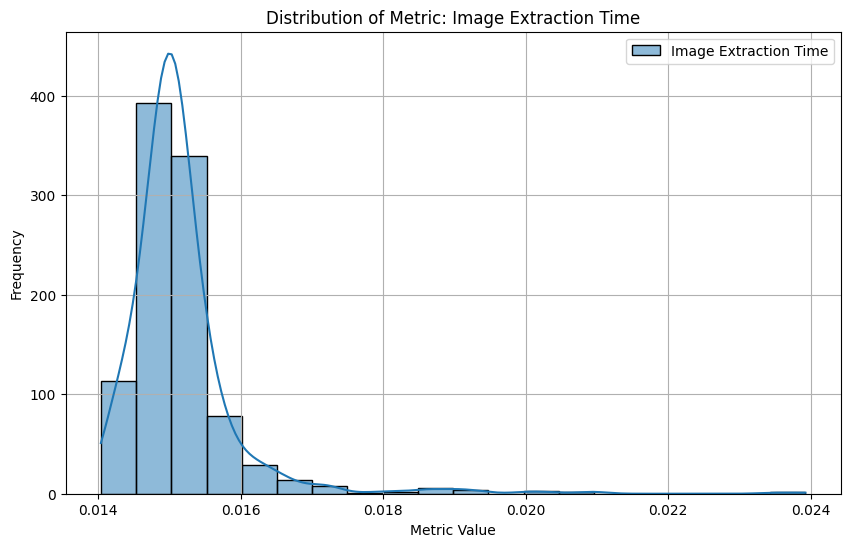

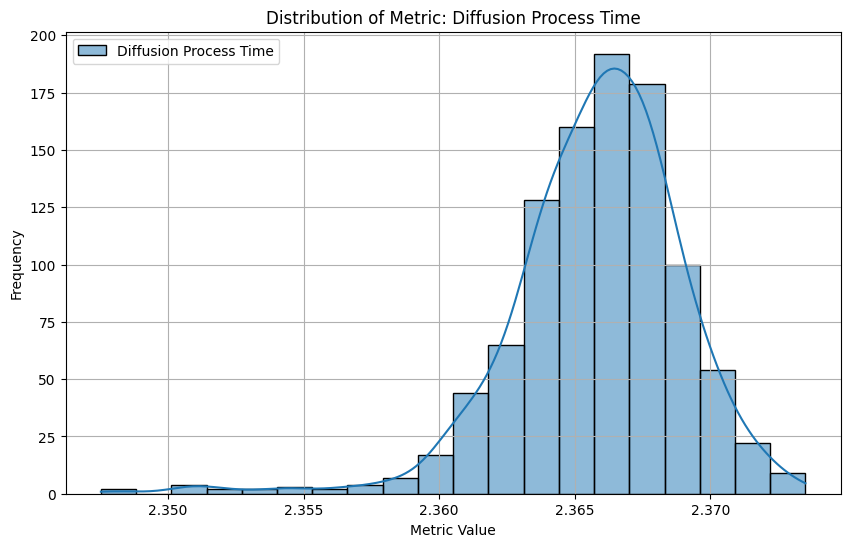

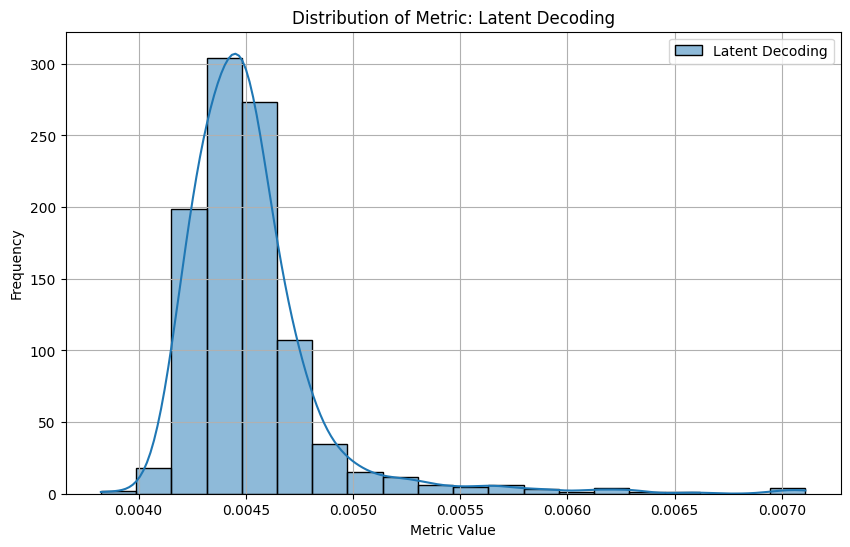

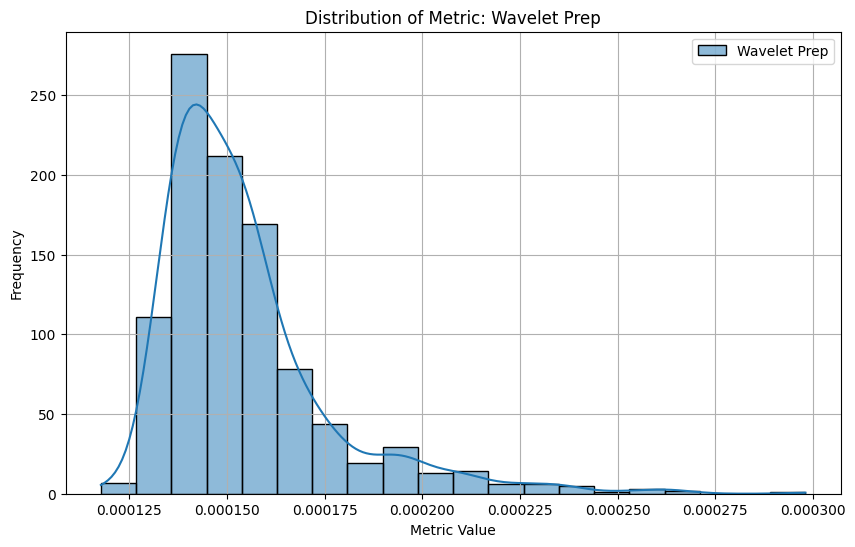

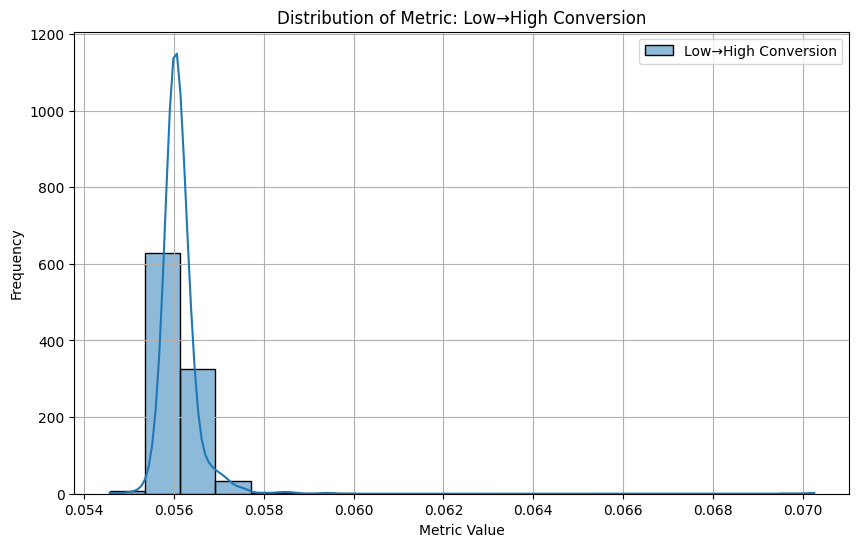

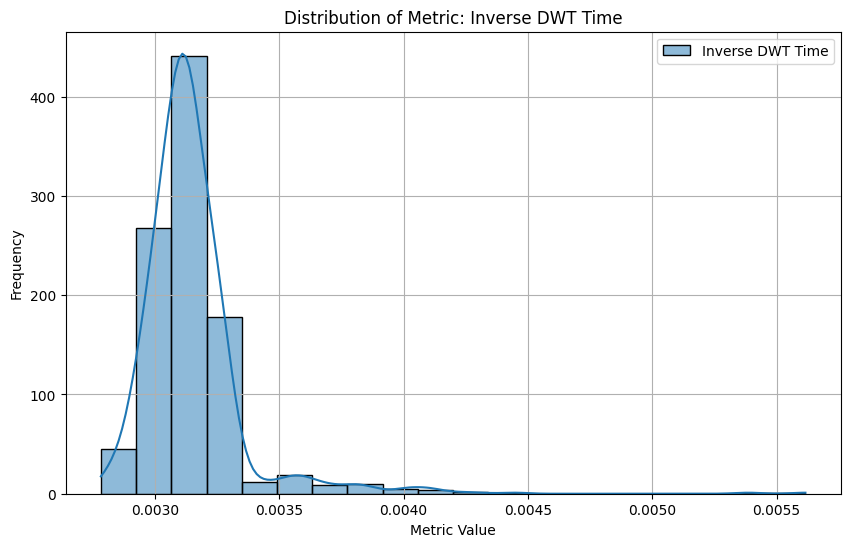

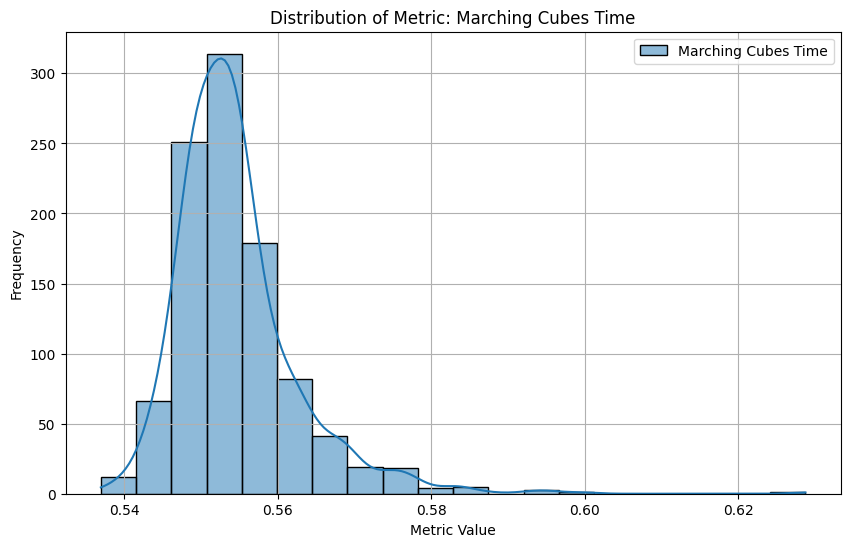

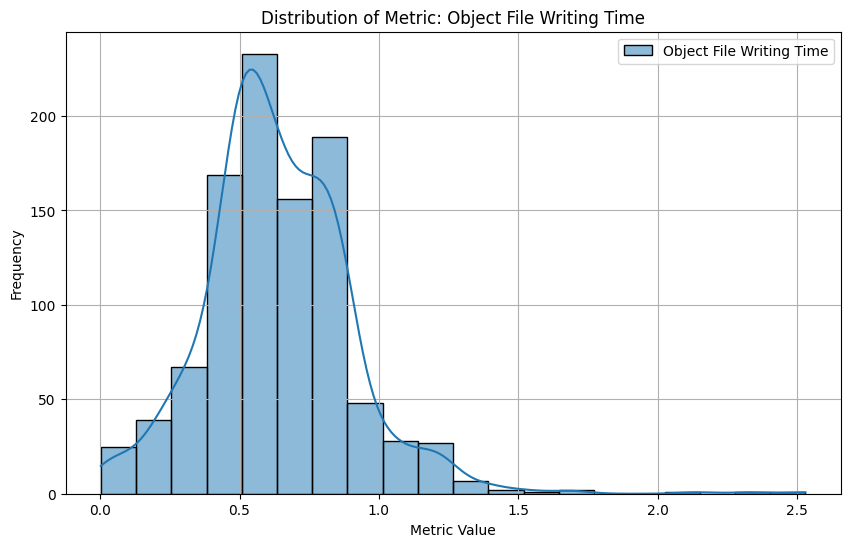

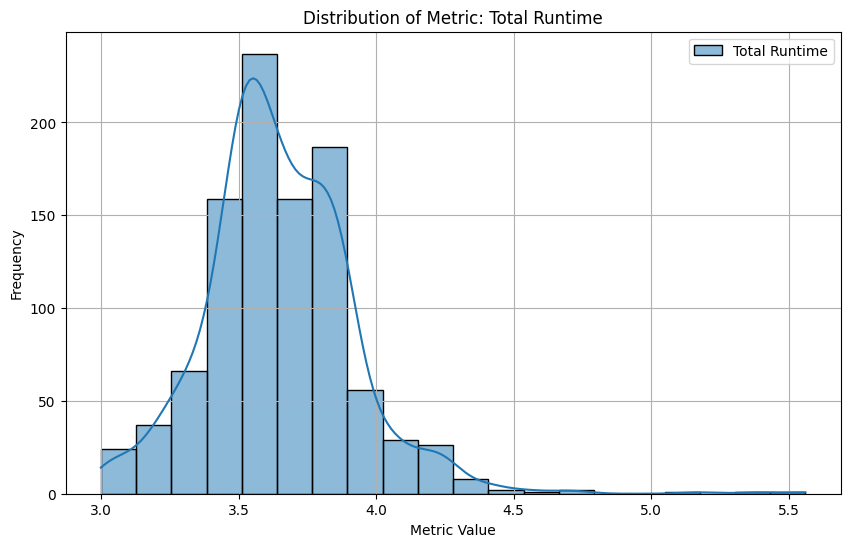

In [12]:
api_key="mqrUAXjKBRul24uX6pxR3gRHX*eyJiYXNlVXJsIjoiaHR0cHM6Ly9jb21ldC5kZXYuY2xvdWRvcy5hdXRvZGVzay5jb20ifQ"
comet_api = API(api_key=api_key)
project_name="wala-time-checks"
workspace="alessandro-giuliano"
experiment_key = '1bf42d8c3ee545628968903512893acf'
experiment_keys = {'Benchmark':'1bf42d8c3ee545628968903512893acf','mcubes_fast_write':'223ac82d90fc4292a33c60cc93e9f929','Simplified Mesh':'7fa0d3b99b0d48588f11da362ed52aca'}
# Retrieve the experiment
experiment = comet_api.get_experiment(workspace, project_name, experiment_keys['Simplified Mesh'])

def retrieve_and_plot(experiment, metric_names=None, metric_display_names=None, plotting=True):
    if metric_names is None:
        metric_names = [
            "Extract Image",
            "Latent Diffusion Time",
            "Latent Decoding Time",
            "Wavelet Preparation Time",
            "Low to Highs conversion",
            "Inverse DWT time elapsed",    
            "mcubes.marching_cubes time",
            "export obj time",
            "Default Delta"
        ]
    if metric_display_names is None:
        metric_display_names = {
            "Extract Image": "Image Extraction Time",
            "Latent Diffusion Time": "Diffusion Process Time",
            "Latent Decoding Time": "Latent Decoding",
            "Wavelet Preparation Time": "Wavelet Prep",
            "Low to Highs conversion": "Low→High Conversion",
            "Inverse DWT time elapsed": "Inverse DWT Time",
            "mcubes.marching_cubes time": "Marching Cubes Time",
            "export obj time": "Object File Writing Time",
            "Default Delta": "Total Runtime"
        }

    all_metric_data = {}

    # Plot the distribution of each metric in a separate figure
    for metric_name in metric_names:
        # Retrieve metric data
        metric_data = experiment.get_metrics(metric_name)
        # Extract values and convert to float
        values = [float(point["metricValue"]) for point in metric_data]
        all_metric_data[metric_name] = values

        display_name = metric_display_names.get(metric_name, metric_name)
        
        if plotting:
            plt.figure(figsize=(10, 6))
            sns.histplot(values, kde=True, bins=20, label=display_name)
            plt.xlabel("Metric Value")
            plt.ylabel("Frequency")
            plt.title(f"Distribution of Metric: {display_name}")
            plt.legend()
            plt.grid()
            plt.show()
    
   

    return all_metric_data, metric_names, metric_display_names
 

all_metric_data, metric_names, metric_display_names = retrieve_and_plot(experiment,plotting = True)


In [13]:
def get_stats(experiment, metric_names, display=False):
    """
    Retrieve and calculate statistics for each metric in an experiment.
    Returns the metric statistics dictionary and the Default Delta values.
    Optionally prints the statistics if display=True.
    """
    metric_statistics = {}
    total_sum = 0
    metric_names = [name for name in metric_names if name != "Default Delta"]

    
    for metric_name in metric_names:
        # Retrieve metric data
        metric_data = experiment.get_metrics(metric_name)
        # Extract values and convert to float
        values = [float(point["metricValue"]) for point in metric_data]
        
        # Calculate statistics
        metric_stats = {
            "mean": np.mean(values),
            "median": np.median(values),
            "min": np.min(values),
            "max": np.max(values),
            "sum": np.sum(values)
        }
        metric_statistics[metric_name] = metric_stats
        total_sum += metric_stats["sum"]

    # Retrieve the "Default Delta" metric
    default_delta_data = experiment.get_metrics("Default Delta")
    default_delta_values = [float(point["metricValue"]) for point in default_delta_data]
    default_delta_sum = np.sum(default_delta_values)

    if display:
        print("Metric Statistics:")
        for metric_name, stats in metric_statistics.items():
            print(f"\n{metric_name}:")
            for stat_name, value in stats.items():
                print(f"  {stat_name.capitalize()}: {value:.4f}")

        print(f"\nTotal Sum of All Metrics (excluding Default Delta): {total_sum:.4f}")
        print(f"Default Delta Sum: {default_delta_sum:.4f}")

        # Check if the total sum is close to the Default Delta
        if np.isclose(total_sum, default_delta_sum, atol=20):  # Adjust tolerance as needed
            percentage_difference = (total_sum / default_delta_sum) * 100
            print(f"\nThe total sum of all metrics is {percentage_difference:.2f}% of the Default Delta.")
        else:
            print("\nThe total sum of all metrics is NOT close to the Default Delta.")

    return metric_statistics, default_delta_values
metric_statistics, default_delta_values = get_stats(experiment, metric_names, display = True)


Metric Statistics:

Extract Image:
  Mean: 0.0152
  Median: 0.0150
  Min: 0.0140
  Max: 0.0239
  Sum: 15.0742

Latent Diffusion Time:
  Mean: 2.3658
  Median: 2.3661
  Min: 2.3475
  Max: 2.3735
  Sum: 2356.3378

Latent Decoding Time:
  Mean: 0.0045
  Median: 0.0045
  Min: 0.0038
  Max: 0.0071
  Sum: 4.5064

Wavelet Preparation Time:
  Mean: 0.0002
  Median: 0.0001
  Min: 0.0001
  Max: 0.0003
  Sum: 0.1539

Low to Highs conversion:
  Mean: 0.0561
  Median: 0.0561
  Min: 0.0546
  Max: 0.0703
  Sum: 55.8993

Inverse DWT time elapsed:
  Mean: 0.0031
  Median: 0.0031
  Min: 0.0028
  Max: 0.0056
  Sum: 3.1364

mcubes.marching_cubes time:
  Mean: 0.5546
  Median: 0.5532
  Min: 0.5370
  Max: 0.6287
  Sum: 552.3800

export obj time:
  Mean: 0.6381
  Median: 0.6137
  Min: 0.0027
  Max: 2.5299
  Sum: 635.5279

Total Sum of All Metrics (excluding Default Delta): 3623.0159
Default Delta Sum: 3634.7231

The total sum of all metrics is 99.68% of the Default Delta.


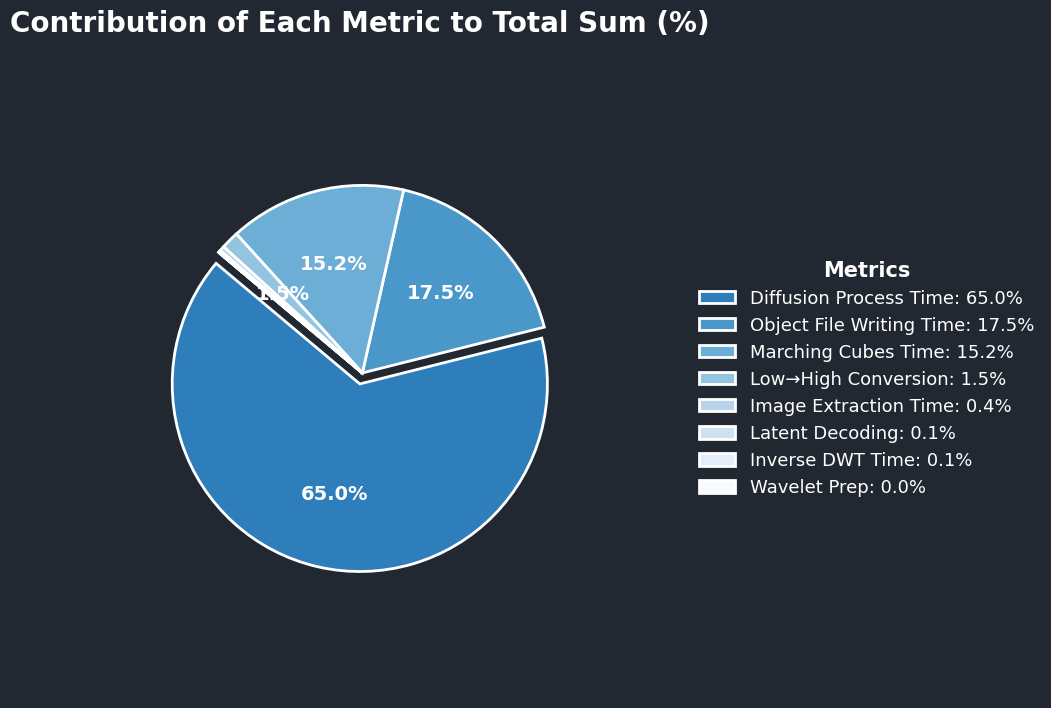

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metric_pie(metric_statistics, metric_display_names, title='Contribution of Each Metric to Total Sum (%)'):
    plt.rcParams['font.family'] = 'DejaVu Sans'

    labels = []
    sizes = []
    for metric_name, stats in metric_statistics.items():
        display_name = metric_display_names.get(metric_name, metric_name)
        labels.append(display_name)
        sizes.append(stats["sum"])

    # Calculate percentages
    total = sum(sizes)
    percentages = [size / total * 100 for size in sizes]

    # Sort by size (descending)
    sorted_indices = np.argsort(sizes)[::-1]
    labels = [labels[i] for i in sorted_indices]
    sizes = [sizes[i] for i in sorted_indices]
    percentages = [percentages[i] for i in sorted_indices]

    # Use an inverted (reversed) colormap for light slices
    cmap = plt.get_cmap('Blues_r')
    colors = [cmap(0.3 + 0.7 * i / (len(labels)-1)) for i in range(len(labels))]

    # Explode the largest slice
    explode = [0.06 if i == 0 else 0 for i in range(len(labels))]

    fig, ax = plt.subplots(figsize=(11, 8))
    fig.patch.set_facecolor('#222831')  # Dark background
    ax.set_facecolor('#222831')

    # Pie chart with white edge, no shadow
    wedges, texts, autotexts = ax.pie(
        sizes,
        colors=colors,
        startangle=140,
        autopct=lambda pct: f"{pct:.1f}%" if pct > 0.5 else '',
        textprops={'fontsize': 14, 'fontweight': 'bold', 'color': 'white'},
        explode=explode,
        wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True}
    )

    # Add a legend with full labels and percentages
    legend_labels = [f"{label}: {percent:.1f}%" for label, percent in zip(labels, percentages)]
    legend = ax.legend(
        wedges, legend_labels, title="Metrics", loc="center left",
        bbox_to_anchor=(1.05, 0.5), fontsize=13, title_fontsize=15, frameon=False, labelcolor='white'
    )
    plt.setp(legend.get_title(), fontweight='bold', color='white')

    plt.title(title, fontsize=20, fontweight='bold', pad=20, color='white')
    plt.axis('equal')
    plt.tight_layout(pad=4)
    plt.show()

plot_metric_pie(metric_statistics,metric_display_names)

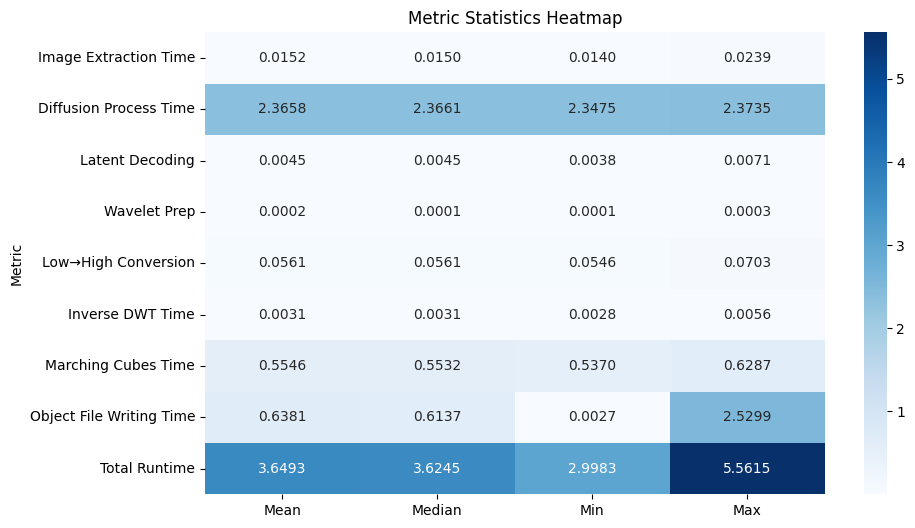

In [15]:

def plot_metric_heatmap(
    metric_statistics,
    metric_display_names,
    default_delta_values,
    include_min=True,
    include_max=True,
    include_median=True,
    title="Metric Statistics Heatmap"
):
    # Prepare columns based on options
    columns = ["Metric", "Mean"]
    if include_median:
        columns.append("Median")
    if include_min:
        columns.append("Min")
    if include_max:
        columns.append("Max")

    data = {col: [] for col in columns}

    for metric_name, stats in metric_statistics.items():
        display_name = metric_display_names.get(metric_name, metric_name)
        data["Metric"].append(display_name)
        data["Mean"].append(stats["mean"])
        if include_median:
            data["Median"].append(stats["median"])
        if include_min:
            data["Min"].append(stats["min"])
        if include_max:
            data["Max"].append(stats["max"])

    # Add Default Delta statistics as "Total Runtime"
    default_delta_stats = {
        "mean": np.mean(default_delta_values),
        "median": np.median(default_delta_values),
        "min": np.min(default_delta_values),
        "max": np.max(default_delta_values)
    }
    data["Metric"].append("Total Runtime")
    data["Mean"].append(default_delta_stats["mean"])
    if include_median:
        data["Median"].append(default_delta_stats["median"])
    if include_min:
        data["Min"].append(default_delta_stats["min"])
    if include_max:
        data["Max"].append(default_delta_stats["max"])

    df = pd.DataFrame(data)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.set_index("Metric"), annot=True, fmt=".4f", cmap="Blues")
    plt.title(title)
    plt.show()

plot_metric_heatmap(
    metric_statistics,
    metric_display_names,
    default_delta_values,
    include_min=True,
    include_max=True,
    include_median=True
)

#### Display Comparisons

WaLa Original: mean = 2.5208, std = 1.1495
WaLa Simplified Mesh: mean = 0.6381, std = 0.2682


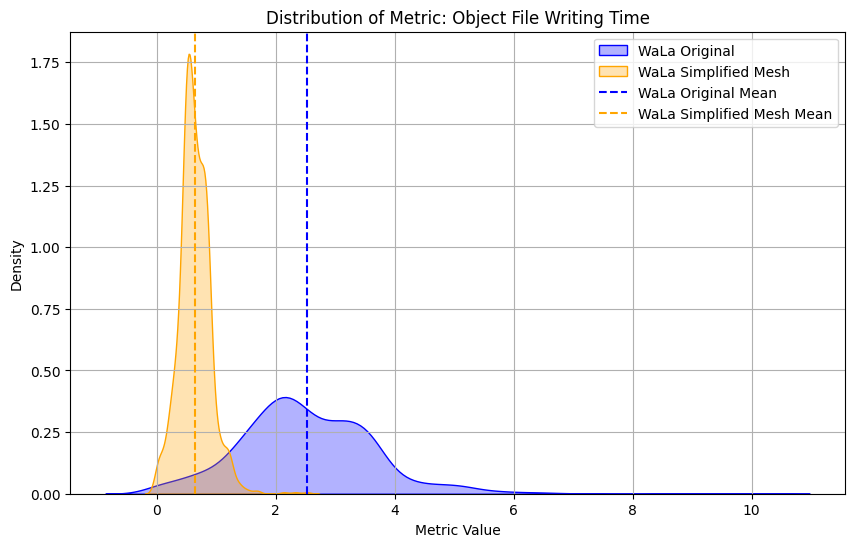

Percentage change in mean: -74.69%
WaLa Original: mean = 5.5203, std = 1.1545
WaLa Simplified Mesh: mean = 3.6493, std = 0.2728


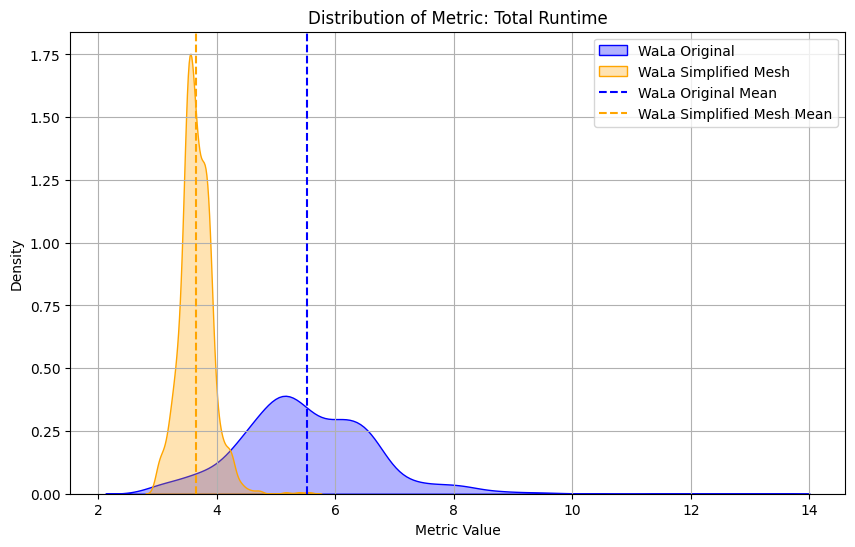

Percentage change in mean: -33.89%


In [18]:
def compare_metric_distribution(
    experiment1, experiment2, 
    metric_name, 
    label1="Experiment 1", 
    label2="Experiment 2", 
    display_name=None
):
    # Retrieve metric data for both experiments
    values1 = [float(point["metricValue"]) for point in experiment1.get_metrics(metric_name)]
    values2 = [float(point["metricValue"]) for point in experiment2.get_metrics(metric_name)]
    
    # Calculate mean and std
    mean1, std1 = np.mean(values1), np.std(values1)
    mean2, std2 = np.mean(values2), np.std(values2)
    
    # Print mean and std
    print(f"{label1}: mean = {mean1:.4f}, std = {std1:.4f}")
    print(f"{label2}: mean = {mean2:.4f}, std = {std2:.4f}")
    
    plt.figure(figsize=(10, 6))
    # KDE plots
    sns.kdeplot(values1, color='blue', label=label1, fill=True, alpha=0.3)
    sns.kdeplot(values2, color='orange', label=label2, fill=True, alpha=0.3)
    # Plot means
    plt.axvline(mean1, color='blue', linestyle='--', label=f"{label1} Mean")
    plt.axvline(mean2, color='orange', linestyle='--', label=f"{label2} Mean")
    
    # Annotate mean and std on the plot
    #plt.text(mean1, plt.ylim()[1]*0.9, f"μ={mean1:.2f}\nσ={std1:.2f}", color='blue', ha='center')
    #plt.text(mean2, plt.ylim()[1]*0.8, f"μ={mean2:.2f}\nσ={std2:.2f}", color='orange', ha='center')
    
    plt.xlabel("Metric Value")
    plt.ylabel("Density")
    plt.title(f"Distribution of Metric: {display_name or metric_name}")
    plt.legend()
    plt.grid()
    plt.show()

    # Print percentage change in means
    if mean1 != 0:
        pct_change = ((mean2 - mean1) / mean1) * 100
        print(f"Percentage change in mean: {pct_change:.2f}%")
    else:
        print("Cannot compute percentage change: mean of first experiment is zero.")

# Retrieve both experiments
experiment1 = comet_api.get_experiment(workspace, project_name, experiment_keys['Benchmark'])
experiment2 = comet_api.get_experiment(workspace, project_name, experiment_keys['Simplified Mesh'])


# Compare "export obj time"
compare_metric_distribution(
    experiment1, experiment2, 
    metric_name="export obj time", 
    label1="WaLa Original", 
    label2="WaLa Simplified Mesh", 
    display_name="Object File Writing Time"
)

# Compare "Default Delta" (total runtime)
compare_metric_distribution(
    experiment1, experiment2, 
    metric_name="Default Delta", 
    label1="WaLa Original", 
    label2="WaLa Simplified Mesh",
    display_name="Total Runtime"
)



### Custom Optimization Implementations

#### Mcubes object export/ write object to file

In [29]:

def export_obj_original(vertices: np.ndarray, triangles: np.ndarray, filename: str, flip_normals: bool = False):
    """
    Export a 3D mesh to a Wavefront (.obj) file.

    If `flip_normals` is True, reverses the order of the vertices in each face
    to flip the normals. Default is False.
    """

    with open(filename, 'w') as fh:

        for v in vertices:
            fh.write("v {} {} {}\n".format(*v))

        if not flip_normals:
            for f in triangles:
                fh.write("f {} {} {}\n".format(*(f + 1)))
        else:
            for f in triangles:
                fh.write("f {} {} {}\n".format(*(f[::-1] + 1)))


def export_obj_fast(vertices: np.ndarray, triangles: np.ndarray, filename: str, flip_normals: bool = False):
    """
    Export a 3D mesh to a Wavefront (.obj) file, optimized for speed.
    """
    with open(filename, 'w') as fh:
        # Write vertices
        np.savetxt(fh, vertices, fmt='v %.6f %.6f %.6f')
        # Prepare faces (OBJ is 1-based indexing)
        if not flip_normals:
            np.savetxt(fh, triangles + 1, fmt='f %d %d %d')
        else:
            np.savetxt(fh, triangles[:, ::-1] + 1, fmt='f %d %d %d')

In [31]:
import numpy as np
import time
import mcubes.exporter

# Generate a large random mesh for testing
num_vertices = 100_000
num_faces = 200_000

vertices = np.random.rand(num_vertices, 3)
triangles = np.random.randint(0, num_vertices, size=(num_faces, 3))

def benchmark_export(func, vertices, triangles, filename, flip_normals=False):
    start = time.time()
    func(vertices, triangles, filename, flip_normals)
    end = time.time()
    return end - start

# Test and compare
filename1 = "test_original.obj"
filename2 = "test_optimized.obj"

t1 = benchmark_export(export_obj_fast, vertices, triangles, filename1)
t2 = benchmark_export(export_obj_original, vertices, triangles, filename2)

print(f"Original export_obj_original time: {t2:.4f} seconds")
print(f"Optimized export_obj time: {t1:.4f} seconds")
print(f"Speedup: {t2/t1:.2f}x faster")

Original export_obj_original time: 1.1878 seconds
Optimized export_obj time: 0.6864 seconds
Speedup: 1.73x faster
